### post processing and paper plot preparation
#### copy from 39_Synthetic_TC_landfall_intensity_11VARS_addLP-stochastic_errors_rndF_woDTL_FS2_EAR5T.ipynb

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point, LineString
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import cm
import seaborn as sns
import netCDF4

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
CONUS = gpd.read_file('Dataset_paper_code_and_data/data/CONUS.shp')
CONUS = CONUS.to_crs({'init': 'epsg:4326'})
CONUS_dissolve = CONUS.dissolve(by='FID_')

%matplotlib inline

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [18]:
# annual storms
num_annual_tc = 851/50
num_annual_tc

17.02

In [19]:
# Here I am loading some custom code to load the IBTrACS data, but you can simply read the netCDF4 and load the same variables
# like: with netCDF4.Dataset('data/IBTrACS.NA.v04r00.nc','r') as nc:
#            rmwmc = nc['usa_rmw'][:]
import sys
sys.path.insert(1, 'C:/2016/85_RAFT/git/branch/TCRainfall/code/shared')
from base import GLOBALS
GLOBALS.set_basedir('C:/2016/85_RAFT/git/TCRainfall')
GLOBALS.load()
GLOBALS.load_tracks()

latmc = GLOBALS.TRACK_LATS[:]
lonmc = GLOBALS.TRACK_LONS[:]
vsmc = GLOBALS.USA_WIND[:]
dates = GLOBALS.DATETIMES[:]
names = GLOBALS.TRACK_NAMES[:]
rmwmc = GLOBALS.RMWS[:]
slpmc = GLOBALS.USA_PRES[:]

#convert masked to nan
def convert_masked_array_to_nan(masked_array):
    temp = np.ma.getdata(masked_array).astype(float)
    temp[np.ma.getmask(masked_array)] = np.nan
    return temp
latmc = convert_masked_array_to_nan(latmc)
lonmc = convert_masked_array_to_nan(lonmc)
vsmc = convert_masked_array_to_nan(vsmc)
slpmc = convert_masked_array_to_nan(slpmc)

#extract yearic and lifetime max intensity
yearic = np.array([pd.to_datetime(dates[i,0]).year for i in range(dates.shape[0])])
vs0_hist_max = np.nanmax(vsmc, axis=1)
#extract hourmc
hourmc = latmc.astype(int)
hourmc[:,:] = np.array([pd.to_datetime(dates[i,:]).hour for i in range(dates.shape[0])])
vs0_hist_max, hourmc

>>> Already loaded globals


C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: All-NaN slice encountered


(array([80., nan, 80., ..., 40., 35., 75.]),
 array([[12, 15, 18, ...,  0,  0,  0],
        [12, 15, 18, ...,  0,  0,  0],
        [12,  0,  0, ...,  0,  0,  0],
        ...,
        [18, 21,  0, ...,  0,  0,  0],
        [12, 15, 18, ...,  0,  0,  0],
        [18, 21,  0, ...,  0,  0,  0]]))

In [20]:
## load Synthetic TC:
with netCDF4.Dataset('C:/2016/85_RAFT/git/branch/TCRainfall/code/intensity/RAFT.NA.v202305.nc', 'r') as nc:
    latsyn = nc['lat'][:]
    lonsyn = nc['lon'][:]
    yearsyn = nc['year'][:]
    jdaysyn = nc['jday'][:]
    basinID = nc['basin_ID'][:]
    storm_ID = nc['storm_ID'][:]
    vmaxsyn = nc['vmax'][:]
    mslpsyn = nc['mslp'][:]
    rmaxsyn = nc['rmax'][:]
    
for itrack in range(latsyn.shape[0]):
    for istep in range(latsyn.shape[1]):
        # effectively cutoff at 15 knots. In case lat and lon are not nan after 15 knots, terminate them.
        if not np.isnan(vmaxsyn[itrack,istep]) and not vmaxsyn[itrack,istep]>=15:
            latsyn[itrack,istep:] = np.nan
            lonsyn[itrack,istep:] = np.nan
            vmaxsyn[itrack,istep:] = np.nan
            
vs0_syn_max = np.nanmax(vmaxsyn, axis=1)

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered


### Record translation speed

In [57]:
def record_translationspd(lonmc, latmc, obs=False):
    '''record the zonal and meridional translation speed in list. Only record the 6 hourly displacement in degree'''
    zonaltranspd_ls, meridionaltranspd_ls = [], []
    for i in range(lonmc.shape[0]):
        # for IBTRACS, need to filter out time steps that are not 6 hourly, and the first recording is not necessarily 6 hourly
        j_start = 0
        if obs:
            if yearic[i] < 1970:
                continue
#             else:
#                 if i > yearic[yearic>1970].shape[0]:
#                     break
        if obs:
            for j in range(0,lonmc.shape[1]):
                if hourmc[i,j] in [0,6,12,18]:
                    j_start = j
                    break
        print(i, end=',')
        lon_old, lat_old = np.nan, np.nan
        for j in range(j_start,lonmc.shape[1]):
            if np.isnan(lonmc[i,j]):
                break
            if obs:
                if not hourmc[i,j] in [0,6,12,18]:
                    continue
#             if not (latmc[i,j]>10 and latmc[i,j]<30 and lonmc[i,j]<-30 and lonmc[i,j]>-80):
#                 continue
            if np.isnan(lat_old):
                lat_old = latmc[i,j]
                lon_old = lonmc[i,j]
                continue
#             if obs:
#                 print(j, dates[i,j], lonmc[i,j], lon_old)
#             else:
#                 print(j, lonmc[i,j], lon_old)
            zonaltranspd = lonmc[i,j] - lon_old
            meridionaltranspd = latmc[i,j] - lat_old
            lat_old = latmc[i,j]
            lon_old = lonmc[i,j]
                
            zonaltranspd_ls.append(zonaltranspd)
            meridionaltranspd_ls.append(meridionaltranspd)

    return zonaltranspd_ls, meridionaltranspd_ls

In [58]:
zonaltranspd_syn_ls, meridionaltranspd_syn_ls = record_translationspd(lonsyn, latsyn, obs=False)
transpd_syn = (np.array(zonaltranspd_syn_ls)**2 + np.array(meridionaltranspd_syn_ls)**2)**0.5
len(zonaltranspd_syn_ls)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2131,2132

,3720,3721,3722,3723,3724,3725,3726,3727,3728,3729,3730,3731,3732,3733,3734,3735,3736,3737,3738,3739,3740,3741,3742,3743,3744,3745,3746,3747,3748,3749,3750,3751,3752,3753,3754,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3768,3769,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779,3780,3781,3782,3783,3784,3785,3786,3787,3788,3789,3790,3791,3792,3793,3794,3795,3796,3797,3798,3799,3800,3801,3802,3803,3804,3805,3806,3807,3808,3809,3810,3811,3812,3813,3814,3815,3816,3817,3818,3819,3820,3821,3822,3823,3824,3825,3826,3827,3828,3829,3830,3831,3832,3833,3834,3835,3836,3837,3838,3839,3840,3841,3842,3843,3844,3845,3846,3847,3848,3849,3850,3851,3852,3853,3854,3855,3856,3857,3858,3859,3860,3861,3862,3863,3864,3865,3866,3867,3868,3869,3870,3871,3872,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882,3883,3884,3885,3886,3887,3888,3889,3890,3891,3892,3893,3894,3895,3896,3897,3898,3899,3900,3901,3902,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,3915,3916,3917,3918,3919

,5523,5524,5525,5526,5527,5528,5529,5530,5531,5532,5533,5534,5535,5536,5537,5538,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548,5549,5550,5551,5552,5553,5554,5555,5556,5557,5558,5559,5560,5561,5562,5563,5564,5565,5566,5567,5568,5569,5570,5571,5572,5573,5574,5575,5576,5577,5578,5579,5580,5581,5582,5583,5584,5585,5586,5587,5588,5589,5590,5591,5592,5593,5594,5595,5596,5597,5598,5599,5600,5601,5602,5603,5604,5605,5606,5607,5608,5609,5610,5611,5612,5613,5614,5615,5616,5617,5618,5619,5620,5621,5622,5623,5624,5625,5626,5627,5628,5629,5630,5631,5632,5633,5634,5635,5636,5637,5638,5639,5640,5641,5642,5643,5644,5645,5646,5647,5648,5649,5650,5651,5652,5653,5654,5655,5656,5657,5658,5659,5660,5661,5662,5663,5664,5665,5666,5667,5668,5669,5670,5671,5672,5673,5674,5675,5676,5677,5678,5679,5680,5681,5682,5683,5684,5685,5686,5687,5688,5689,5690,5691,5692,5693,5694,5695,5696,5697,5698,5699,5700,5701,5702,5703,5704,5705,5706,5707,5708,5709,5710,5711,5712,5713,5714,5715,5716,5717,5718,5719,5720,5721,5722

,7269,7270,7271,7272,7273,7274,7275,7276,7277,7278,7279,7280,7281,7282,7283,7284,7285,7286,7287,7288,7289,7290,7291,7292,7293,7294,7295,7296,7297,7298,7299,7300,7301,7302,7303,7304,7305,7306,7307,7308,7309,7310,7311,7312,7313,7314,7315,7316,7317,7318,7319,7320,7321,7322,7323,7324,7325,7326,7327,7328,7329,7330,7331,7332,7333,7334,7335,7336,7337,7338,7339,7340,7341,7342,7343,7344,7345,7346,7347,7348,7349,7350,7351,7352,7353,7354,7355,7356,7357,7358,7359,7360,7361,7362,7363,7364,7365,7366,7367,7368,7369,7370,7371,7372,7373,7374,7375,7376,7377,7378,7379,7380,7381,7382,7383,7384,7385,7386,7387,7388,7389,7390,7391,7392,7393,7394,7395,7396,7397,7398,7399,7400,7401,7402,7403,7404,7405,7406,7407,7408,7409,7410,7411,7412,7413,7414,7415,7416,7417,7418,7419,7420,7421,7422,7423,7424,7425,7426,7427,7428,7429,7430,7431,7432,7433,7434,7435,7436,7437,7438,7439,7440,7441,7442,7443,7444,7445,7446,7447,7448,7449,7450,7451,7452,7453,7454,7455,7456,7457,7458,7459,7460,7461,7462,7463,7464,7465,7466,7467,7468

,8960,8961,8962,8963,8964,8965,8966,8967,8968,8969,8970,8971,8972,8973,8974,8975,8976,8977,8978,8979,8980,8981,8982,8983,8984,8985,8986,8987,8988,8989,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999,9000,9001,9002,9003,9004,9005,9006,9007,9008,9009,9010,9011,9012,9013,9014,9015,9016,9017,9018,9019,9020,9021,9022,9023,9024,9025,9026,9027,9028,9029,9030,9031,9032,9033,9034,9035,9036,9037,9038,9039,9040,9041,9042,9043,9044,9045,9046,9047,9048,9049,9050,9051,9052,9053,9054,9055,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065,9066,9067,9068,9069,9070,9071,9072,9073,9074,9075,9076,9077,9078,9079,9080,9081,9082,9083,9084,9085,9086,9087,9088,9089,9090,9091,9092,9093,9094,9095,9096,9097,9098,9099,9100,9101,9102,9103,9104,9105,9106,9107,9108,9109,9110,9111,9112,9113,9114,9115,9116,9117,9118,9119,9120,9121,9122,9123,9124,9125,9126,9127,9128,9129,9130,9131,9132,9133,9134,9135,9136,9137,9138,9139,9140,9141,9142,9143,9144,9145,9146,9147,9148,9149,9150,9151,9152,9153,9154,9155,9156,9157,9158,9159

10592,10593,10594,10595,10596,10597,10598,10599,10600,10601,10602,10603,10604,10605,10606,10607,10608,10609,10610,10611,10612,10613,10614,10615,10616,10617,10618,10619,10620,10621,10622,10623,10624,10625,10626,10627,10628,10629,10630,10631,10632,10633,10634,10635,10636,10637,10638,10639,10640,10641,10642,10643,10644,10645,10646,10647,10648,10649,10650,10651,10652,10653,10654,10655,10656,10657,10658,10659,10660,10661,10662,10663,10664,10665,10666,10667,10668,10669,10670,10671,10672,10673,10674,10675,10676,10677,10678,10679,10680,10681,10682,10683,10684,10685,10686,10687,10688,10689,10690,10691,10692,10693,10694,10695,10696,10697,10698,10699,10700,10701,10702,10703,10704,10705,10706,10707,10708,10709,10710,10711,10712,10713,10714,10715,10716,10717,10718,10719,10720,10721,10722,10723,10724,10725,10726,10727,10728,10729,10730,10731,10732,10733,10734,10735,10736,10737,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747,10748,10749,10750,10751,10752,10753,10754,10755,10756,10757,1075

,12103,12104,12105,12106,12107,12108,12109,12110,12111,12112,12113,12114,12115,12116,12117,12118,12119,12120,12121,12122,12123,12124,12125,12126,12127,12128,12129,12130,12131,12132,12133,12134,12135,12136,12137,12138,12139,12140,12141,12142,12143,12144,12145,12146,12147,12148,12149,12150,12151,12152,12153,12154,12155,12156,12157,12158,12159,12160,12161,12162,12163,12164,12165,12166,12167,12168,12169,12170,12171,12172,12173,12174,12175,12176,12177,12178,12179,12180,12181,12182,12183,12184,12185,12186,12187,12188,12189,12190,12191,12192,12193,12194,12195,12196,12197,12198,12199,12200,12201,12202,12203,12204,12205,12206,12207,12208,12209,12210,12211,12212,12213,12214,12215,12216,12217,12218,12219,12220,12221,12222,12223,12224,12225,12226,12227,12228,12229,12230,12231,12232,12233,12234,12235,12236,12237,12238,12239,12240,12241,12242,12243,12244,12245,12246,12247,12248,12249,12250,12251,12252,12253,12254,12255,12256,12257,12258,12259,12260,12261,12262,12263,12264,12265,12266,12267,12268,122

,13728,13729,13730,13731,13732,13733,13734,13735,13736,13737,13738,13739,13740,13741,13742,13743,13744,13745,13746,13747,13748,13749,13750,13751,13752,13753,13754,13755,13756,13757,13758,13759,13760,13761,13762,13763,13764,13765,13766,13767,13768,13769,13770,13771,13772,13773,13774,13775,13776,13777,13778,13779,13780,13781,13782,13783,13784,13785,13786,13787,13788,13789,13790,13791,13792,13793,13794,13795,13796,13797,13798,13799,13800,13801,13802,13803,13804,13805,13806,13807,13808,13809,13810,13811,13812,13813,13814,13815,13816,13817,13818,13819,13820,13821,13822,13823,13824,13825,13826,13827,13828,13829,13830,13831,13832,13833,13834,13835,13836,13837,13838,13839,13840,13841,13842,13843,13844,13845,13846,13847,13848,13849,13850,13851,13852,13853,13854,13855,13856,13857,13858,13859,13860,13861,13862,13863,13864,13865,13866,13867,13868,13869,13870,13871,13872,13873,13874,13875,13876,13877,13878,13879,13880,13881,13882,13883,13884,13885,13886,13887,13888,13889,13890,13891,13892,13893,138

,15301,15302,15303,15304,15305,15306,15307,15308,15309,15310,15311,15312,15313,15314,15315,15316,15317,15318,15319,15320,15321,15322,15323,15324,15325,15326,15327,15328,15329,15330,15331,15332,15333,15334,15335,15336,15337,15338,15339,15340,15341,15342,15343,15344,15345,15346,15347,15348,15349,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359,15360,15361,15362,15363,15364,15365,15366,15367,15368,15369,15370,15371,15372,15373,15374,15375,15376,15377,15378,15379,15380,15381,15382,15383,15384,15385,15386,15387,15388,15389,15390,15391,15392,15393,15394,15395,15396,15397,15398,15399,15400,15401,15402,15403,15404,15405,15406,15407,15408,15409,15410,15411,15412,15413,15414,15415,15416,15417,15418,15419,15420,15421,15422,15423,15424,15425,15426,15427,15428,15429,15430,15431,15432,15433,15434,15435,15436,15437,15438,15439,15440,15441,15442,15443,15444,15445,15446,15447,15448,15449,15450,15451,15452,15453,15454,15455,15456,15457,15458,15459,15460,15461,15462,15463,15464,15465,15466,154

,16781,16782,16783,16784,16785,16786,16787,16788,16789,16790,16791,16792,16793,16794,16795,16796,16797,16798,16799,16800,16801,16802,16803,16804,16805,16806,16807,16808,16809,16810,16811,16812,16813,16814,16815,16816,16817,16818,16819,16820,16821,16822,16823,16824,16825,16826,16827,16828,16829,16830,16831,16832,16833,16834,16835,16836,16837,16838,16839,16840,16841,16842,16843,16844,16845,16846,16847,16848,16849,16850,16851,16852,16853,16854,16855,16856,16857,16858,16859,16860,16861,16862,16863,16864,16865,16866,16867,16868,16869,16870,16871,16872,16873,16874,16875,16876,16877,16878,16879,16880,16881,16882,16883,16884,16885,16886,16887,16888,16889,16890,16891,16892,16893,16894,16895,16896,16897,16898,16899,16900,16901,16902,16903,16904,16905,16906,16907,16908,16909,16910,16911,16912,16913,16914,16915,16916,16917,16918,16919,16920,16921,16922,16923,16924,16925,16926,16927,16928,16929,16930,16931,16932,16933,16934,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944,16945,16946,169

,18233,18234,18235,18236,18237,18238,18239,18240,18241,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251,18252,18253,18254,18255,18256,18257,18258,18259,18260,18261,18262,18263,18264,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274,18275,18276,18277,18278,18279,18280,18281,18282,18283,18284,18285,18286,18287,18288,18289,18290,18291,18292,18293,18294,18295,18296,18297,18298,18299,18300,18301,18302,18303,18304,18305,18306,18307,18308,18309,18310,18311,18312,18313,18314,18315,18316,18317,18318,18319,18320,18321,18322,18323,18324,18325,18326,18327,18328,18329,18330,18331,18332,18333,18334,18335,18336,18337,18338,18339,18340,18341,18342,18343,18344,18345,18346,18347,18348,18349,18350,18351,18352,18353,18354,18355,18356,18357,18358,18359,18360,18361,18362,18363,18364,18365,18366,18367,18368,18369,18370,18371,18372,18373,18374,18375,18376,18377,18378,18379,18380,18381,18382,18383,18384,18385,18386,18387,18388,18389,18390,18391,18392,18393,18394,18395,18396,18397,18398,183

,19804,19805,19806,19807,19808,19809,19810,19811,19812,19813,19814,19815,19816,19817,19818,19819,19820,19821,19822,19823,19824,19825,19826,19827,19828,19829,19830,19831,19832,19833,19834,19835,19836,19837,19838,19839,19840,19841,19842,19843,19844,19845,19846,19847,19848,19849,19850,19851,19852,19853,19854,19855,19856,19857,19858,19859,19860,19861,19862,19863,19864,19865,19866,19867,19868,19869,19870,19871,19872,19873,19874,19875,19876,19877,19878,19879,19880,19881,19882,19883,19884,19885,19886,19887,19888,19889,19890,19891,19892,19893,19894,19895,19896,19897,19898,19899,19900,19901,19902,19903,19904,19905,19906,19907,19908,19909,19910,19911,19912,19913,19914,19915,19916,19917,19918,19919,19920,19921,19922,19923,19924,19925,19926,19927,19928,19929,19930,19931,19932,19933,19934,19935,19936,19937,19938,19939,19940,19941,19942,19943,19944,19945,19946,19947,19948,19949,19950,19951,19952,19953,19954,19955,19956,19957,19958,19959,19960,19961,19962,19963,19964,19965,19966,19967,19968,19969,199

,21269,21270,21271,21272,21273,21274,21275,21276,21277,21278,21279,21280,21281,21282,21283,21284,21285,21286,21287,21288,21289,21290,21291,21292,21293,21294,21295,21296,21297,21298,21299,21300,21301,21302,21303,21304,21305,21306,21307,21308,21309,21310,21311,21312,21313,21314,21315,21316,21317,21318,21319,21320,21321,21322,21323,21324,21325,21326,21327,21328,21329,21330,21331,21332,21333,21334,21335,21336,21337,21338,21339,21340,21341,21342,21343,21344,21345,21346,21347,21348,21349,21350,21351,21352,21353,21354,21355,21356,21357,21358,21359,21360,21361,21362,21363,21364,21365,21366,21367,21368,21369,21370,21371,21372,21373,21374,21375,21376,21377,21378,21379,21380,21381,21382,21383,21384,21385,21386,21387,21388,21389,21390,21391,21392,21393,21394,21395,21396,21397,21398,21399,21400,21401,21402,21403,21404,21405,21406,21407,21408,21409,21410,21411,21412,21413,21414,21415,21416,21417,21418,21419,21420,21421,21422,21423,21424,21425,21426,21427,21428,21429,21430,21431,21432,21433,21434,214

22785,22786,22787,22788,22789,22790,22791,22792,22793,22794,22795,22796,22797,22798,22799,22800,22801,22802,22803,22804,22805,22806,22807,22808,22809,22810,22811,22812,22813,22814,22815,22816,22817,22818,22819,22820,22821,22822,22823,22824,22825,22826,22827,22828,22829,22830,22831,22832,22833,22834,22835,22836,22837,22838,22839,22840,22841,22842,22843,22844,22845,22846,22847,22848,22849,22850,22851,22852,22853,22854,22855,22856,22857,22858,22859,22860,22861,22862,22863,22864,22865,22866,22867,22868,22869,22870,22871,22872,22873,22874,22875,22876,22877,22878,22879,22880,22881,22882,22883,22884,22885,22886,22887,22888,22889,22890,22891,22892,22893,22894,22895,22896,22897,22898,22899,22900,22901,22902,22903,22904,22905,22906,22907,22908,22909,22910,22911,22912,22913,22914,22915,22916,22917,22918,22919,22920,22921,22922,22923,22924,22925,22926,22927,22928,22929,22930,22931,22932,22933,22934,22935,22936,22937,22938,22939,22940,22941,22942,22943,22944,22945,22946,22947,22948,22949,22950,2295

,24392,24393,24394,24395,24396,24397,24398,24399,24400,24401,24402,24403,24404,24405,24406,24407,24408,24409,24410,24411,24412,24413,24414,24415,24416,24417,24418,24419,24420,24421,24422,24423,24424,24425,24426,24427,24428,24429,24430,24431,24432,24433,24434,24435,24436,24437,24438,24439,24440,24441,24442,24443,24444,24445,24446,24447,24448,24449,24450,24451,24452,24453,24454,24455,24456,24457,24458,24459,24460,24461,24462,24463,24464,24465,24466,24467,24468,24469,24470,24471,24472,24473,24474,24475,24476,24477,24478,24479,24480,24481,24482,24483,24484,24485,24486,24487,24488,24489,24490,24491,24492,24493,24494,24495,24496,24497,24498,24499,24500,24501,24502,24503,24504,24505,24506,24507,24508,24509,24510,24511,24512,24513,24514,24515,24516,24517,24518,24519,24520,24521,24522,24523,24524,24525,24526,24527,24528,24529,24530,24531,24532,24533,24534,24535,24536,24537,24538,24539,24540,24541,24542,24543,24544,24545,24546,24547,24548,24549,24550,24551,24552,24553,24554,24555,24556,24557,245

,25878,25879,25880,25881,25882,25883,25884,25885,25886,25887,25888,25889,25890,25891,25892,25893,25894,25895,25896,25897,25898,25899,25900,25901,25902,25903,25904,25905,25906,25907,25908,25909,25910,25911,25912,25913,25914,25915,25916,25917,25918,25919,25920,25921,25922,25923,25924,25925,25926,25927,25928,25929,25930,25931,25932,25933,25934,25935,25936,25937,25938,25939,25940,25941,25942,25943,25944,25945,25946,25947,25948,25949,25950,25951,25952,25953,25954,25955,25956,25957,25958,25959,25960,25961,25962,25963,25964,25965,25966,25967,25968,25969,25970,25971,25972,25973,25974,25975,25976,25977,25978,25979,25980,25981,25982,25983,25984,25985,25986,25987,25988,25989,25990,25991,25992,25993,25994,25995,25996,25997,25998,25999,26000,26001,26002,26003,26004,26005,26006,26007,26008,26009,26010,26011,26012,26013,26014,26015,26016,26017,26018,26019,26020,26021,26022,26023,26024,26025,26026,26027,26028,26029,26030,26031,26032,26033,26034,26035,26036,26037,26038,26039,26040,26041,26042,26043,260

,27420,27421,27422,27423,27424,27425,27426,27427,27428,27429,27430,27431,27432,27433,27434,27435,27436,27437,27438,27439,27440,27441,27442,27443,27444,27445,27446,27447,27448,27449,27450,27451,27452,27453,27454,27455,27456,27457,27458,27459,27460,27461,27462,27463,27464,27465,27466,27467,27468,27469,27470,27471,27472,27473,27474,27475,27476,27477,27478,27479,27480,27481,27482,27483,27484,27485,27486,27487,27488,27489,27490,27491,27492,27493,27494,27495,27496,27497,27498,27499,27500,27501,27502,27503,27504,27505,27506,27507,27508,27509,27510,27511,27512,27513,27514,27515,27516,27517,27518,27519,27520,27521,27522,27523,27524,27525,27526,27527,27528,27529,27530,27531,27532,27533,27534,27535,27536,27537,27538,27539,27540,27541,27542,27543,27544,27545,27546,27547,27548,27549,27550,27551,27552,27553,27554,27555,27556,27557,27558,27559,27560,27561,27562,27563,27564,27565,27566,27567,27568,27569,27570,27571,27572,27573,27574,27575,27576,27577,27578,27579,27580,27581,27582,27583,27584,27585,275

28939,28940,28941,28942,28943,28944,28945,28946,28947,28948,28949,28950,28951,28952,28953,28954,28955,28956,28957,28958,28959,28960,28961,28962,28963,28964,28965,28966,28967,28968,28969,28970,28971,28972,28973,28974,28975,28976,28977,28978,28979,28980,28981,28982,28983,28984,28985,28986,28987,28988,28989,28990,28991,28992,28993,28994,28995,28996,28997,28998,28999,29000,29001,29002,29003,29004,29005,29006,29007,29008,29009,29010,29011,29012,29013,29014,29015,29016,29017,29018,29019,29020,29021,29022,29023,29024,29025,29026,29027,29028,29029,29030,29031,29032,29033,29034,29035,29036,29037,29038,29039,29040,29041,29042,29043,29044,29045,29046,29047,29048,29049,29050,29051,29052,29053,29054,29055,29056,29057,29058,29059,29060,29061,29062,29063,29064,29065,29066,29067,29068,29069,29070,29071,29072,29073,29074,29075,29076,29077,29078,29079,29080,29081,29082,29083,29084,29085,29086,29087,29088,29089,29090,29091,29092,29093,29094,29095,29096,29097,29098,29099,29100,29101,29102,29103,29104,2910

30516,30517,30518,30519,30520,30521,30522,30523,30524,30525,30526,30527,30528,30529,30530,30531,30532,30533,30534,30535,30536,30537,30538,30539,30540,30541,30542,30543,30544,30545,30546,30547,30548,30549,30550,30551,30552,30553,30554,30555,30556,30557,30558,30559,30560,30561,30562,30563,30564,30565,30566,30567,30568,30569,30570,30571,30572,30573,30574,30575,30576,30577,30578,30579,30580,30581,30582,30583,30584,30585,30586,30587,30588,30589,30590,30591,30592,30593,30594,30595,30596,30597,30598,30599,30600,30601,30602,30603,30604,30605,30606,30607,30608,30609,30610,30611,30612,30613,30614,30615,30616,30617,30618,30619,30620,30621,30622,30623,30624,30625,30626,30627,30628,30629,30630,30631,30632,30633,30634,30635,30636,30637,30638,30639,30640,30641,30642,30643,30644,30645,30646,30647,30648,30649,30650,30651,30652,30653,30654,30655,30656,30657,30658,30659,30660,30661,30662,30663,30664,30665,30666,30667,30668,30669,30670,30671,30672,30673,30674,30675,30676,30677,30678,30679,30680,30681,3068

31967,31968,31969,31970,31971,31972,31973,31974,31975,31976,31977,31978,31979,31980,31981,31982,31983,31984,31985,31986,31987,31988,31989,31990,31991,31992,31993,31994,31995,31996,31997,31998,31999,32000,32001,32002,32003,32004,32005,32006,32007,32008,32009,32010,32011,32012,32013,32014,32015,32016,32017,32018,32019,32020,32021,32022,32023,32024,32025,32026,32027,32028,32029,32030,32031,32032,32033,32034,32035,32036,32037,32038,32039,32040,32041,32042,32043,32044,32045,32046,32047,32048,32049,32050,32051,32052,32053,32054,32055,32056,32057,32058,32059,32060,32061,32062,32063,32064,32065,32066,32067,32068,32069,32070,32071,32072,32073,32074,32075,32076,32077,32078,32079,32080,32081,32082,32083,32084,32085,32086,32087,32088,32089,32090,32091,32092,32093,32094,32095,32096,32097,32098,32099,32100,32101,32102,32103,32104,32105,32106,32107,32108,32109,32110,32111,32112,32113,32114,32115,32116,32117,32118,32119,32120,32121,32122,32123,32124,32125,32126,32127,32128,32129,32130,32131,32132,3213

,33426,33427,33428,33429,33430,33431,33432,33433,33434,33435,33436,33437,33438,33439,33440,33441,33442,33443,33444,33445,33446,33447,33448,33449,33450,33451,33452,33453,33454,33455,33456,33457,33458,33459,33460,33461,33462,33463,33464,33465,33466,33467,33468,33469,33470,33471,33472,33473,33474,33475,33476,33477,33478,33479,33480,33481,33482,33483,33484,33485,33486,33487,33488,33489,33490,33491,33492,33493,33494,33495,33496,33497,33498,33499,33500,33501,33502,33503,33504,33505,33506,33507,33508,33509,33510,33511,33512,33513,33514,33515,33516,33517,33518,33519,33520,33521,33522,33523,33524,33525,33526,33527,33528,33529,33530,33531,33532,33533,33534,33535,33536,33537,33538,33539,33540,33541,33542,33543,33544,33545,33546,33547,33548,33549,33550,33551,33552,33553,33554,33555,33556,33557,33558,33559,33560,33561,33562,33563,33564,33565,33566,33567,33568,33569,33570,33571,33572,33573,33574,33575,33576,33577,33578,33579,33580,33581,33582,33583,33584,33585,33586,33587,33588,33589,33590,33591,335

34925,34926,34927,34928,34929,34930,34931,34932,34933,34934,34935,34936,34937,34938,34939,34940,34941,34942,34943,34944,34945,34946,34947,34948,34949,34950,34951,34952,34953,34954,34955,34956,34957,34958,34959,34960,34961,34962,34963,34964,34965,34966,34967,34968,34969,34970,34971,34972,34973,34974,34975,34976,34977,34978,34979,34980,34981,34982,34983,34984,34985,34986,34987,34988,34989,34990,34991,34992,34993,34994,34995,34996,34997,34998,34999,35000,35001,35002,35003,35004,35005,35006,35007,35008,35009,35010,35011,35012,35013,35014,35015,35016,35017,35018,35019,35020,35021,35022,35023,35024,35025,35026,35027,35028,35029,35030,35031,35032,35033,35034,35035,35036,35037,35038,35039,35040,35041,35042,35043,35044,35045,35046,35047,35048,35049,35050,35051,35052,35053,35054,35055,35056,35057,35058,35059,35060,35061,35062,35063,35064,35065,35066,35067,35068,35069,35070,35071,35072,35073,35074,35075,35076,35077,35078,35079,35080,35081,35082,35083,35084,35085,35086,35087,35088,35089,35090,3509

36479,36480,36481,36482,36483,36484,36485,36486,36487,36488,36489,36490,36491,36492,36493,36494,36495,36496,36497,36498,36499,36500,36501,36502,36503,36504,36505,36506,36507,36508,36509,36510,36511,36512,36513,36514,36515,36516,36517,36518,36519,36520,36521,36522,36523,36524,36525,36526,36527,36528,36529,36530,36531,36532,36533,36534,36535,36536,36537,36538,36539,36540,36541,36542,36543,36544,36545,36546,36547,36548,36549,36550,36551,36552,36553,36554,36555,36556,36557,36558,36559,36560,36561,36562,36563,36564,36565,36566,36567,36568,36569,36570,36571,36572,36573,36574,36575,36576,36577,36578,36579,36580,36581,36582,36583,36584,36585,36586,36587,36588,36589,36590,36591,36592,36593,36594,36595,36596,36597,36598,36599,36600,36601,36602,36603,36604,36605,36606,36607,36608,36609,36610,36611,36612,36613,36614,36615,36616,36617,36618,36619,36620,36621,36622,36623,36624,36625,36626,36627,36628,36629,36630,36631,36632,36633,36634,36635,36636,36637,36638,36639,36640,36641,36642,36643,36644,3664

38059,38060,38061,38062,38063,38064,38065,38066,38067,38068,38069,38070,38071,38072,38073,38074,38075,38076,38077,38078,38079,38080,38081,38082,38083,38084,38085,38086,38087,38088,38089,38090,38091,38092,38093,38094,38095,38096,38097,38098,38099,38100,38101,38102,38103,38104,38105,38106,38107,38108,38109,38110,38111,38112,38113,38114,38115,38116,38117,38118,38119,38120,38121,38122,38123,38124,38125,38126,38127,38128,38129,38130,38131,38132,38133,38134,38135,38136,38137,38138,38139,38140,38141,38142,38143,38144,38145,38146,38147,38148,38149,38150,38151,38152,38153,38154,38155,38156,38157,38158,38159,38160,38161,38162,38163,38164,38165,38166,38167,38168,38169,38170,38171,38172,38173,38174,38175,38176,38177,38178,38179,38180,38181,38182,38183,38184,38185,38186,38187,38188,38189,38190,38191,38192,38193,38194,38195,38196,38197,38198,38199,38200,38201,38202,38203,38204,38205,38206,38207,38208,38209,38210,38211,38212,38213,38214,38215,38216,38217,38218,38219,38220,38221,38222,38223,38224,3822

39536,39537,39538,39539,39540,39541,39542,39543,39544,39545,39546,39547,39548,39549,39550,39551,39552,39553,39554,39555,39556,39557,39558,39559,39560,39561,39562,39563,39564,39565,39566,39567,39568,39569,39570,39571,39572,39573,39574,39575,39576,39577,39578,39579,39580,39581,39582,39583,39584,39585,39586,39587,39588,39589,39590,39591,39592,39593,39594,39595,39596,39597,39598,39599,39600,39601,39602,39603,39604,39605,39606,39607,39608,39609,39610,39611,39612,39613,39614,39615,39616,39617,39618,39619,39620,39621,39622,39623,39624,39625,39626,39627,39628,39629,39630,39631,39632,39633,39634,39635,39636,39637,39638,39639,39640,39641,39642,39643,39644,39645,39646,39647,39648,39649,39650,39651,39652,39653,39654,39655,39656,39657,39658,39659,39660,39661,39662,39663,39664,39665,39666,39667,39668,39669,39670,39671,39672,39673,39674,39675,39676,39677,39678,39679,39680,39681,39682,39683,39684,39685,39686,39687,39688,39689,39690,39691,39692,39693,39694,39695,39696,39697,39698,39699,39700,39701,3970

,40934,40935,40936,40937,40938,40939,40940,40941,40942,40943,40944,40945,40946,40947,40948,40949,40950,40951,40952,40953,40954,40955,40956,40957,40958,40959,40960,40961,40962,40963,40964,40965,40966,40967,40968,40969,40970,40971,40972,40973,40974,40975,40976,40977,40978,40979,40980,40981,40982,40983,40984,40985,40986,40987,40988,40989,40990,40991,40992,40993,40994,40995,40996,40997,40998,40999,41000,41001,41002,41003,41004,41005,41006,41007,41008,41009,41010,41011,41012,41013,41014,41015,41016,41017,41018,41019,41020,41021,41022,41023,41024,41025,41026,41027,41028,41029,41030,41031,41032,41033,41034,41035,41036,41037,41038,41039,41040,41041,41042,41043,41044,41045,41046,41047,41048,41049,41050,41051,41052,41053,41054,41055,41056,41057,41058,41059,41060,41061,41062,41063,41064,41065,41066,41067,41068,41069,41070,41071,41072,41073,41074,41075,41076,41077,41078,41079,41080,41081,41082,41083,41084,41085,41086,41087,41088,41089,41090,41091,41092,41093,41094,41095,41096,41097,41098,41099,411

42372,42373,42374,42375,42376,42377,42378,42379,42380,42381,42382,42383,42384,42385,42386,42387,42388,42389,42390,42391,42392,42393,42394,42395,42396,42397,42398,42399,42400,42401,42402,42403,42404,42405,42406,42407,42408,42409,42410,42411,42412,42413,42414,42415,42416,42417,42418,42419,42420,42421,42422,42423,42424,42425,42426,42427,42428,42429,42430,42431,42432,42433,42434,42435,42436,42437,42438,42439,42440,42441,42442,42443,42444,42445,42446,42447,42448,42449,42450,42451,42452,42453,42454,42455,42456,42457,42458,42459,42460,42461,42462,42463,42464,42465,42466,42467,42468,42469,42470,42471,42472,42473,42474,42475,42476,42477,42478,42479,42480,42481,42482,42483,42484,42485,42486,42487,42488,42489,42490,42491,42492,42493,42494,42495,42496,42497,42498,42499,42500,42501,42502,42503,42504,42505,42506,42507,42508,42509,42510,42511,42512,42513,42514,42515,42516,42517,42518,42519,42520,42521,42522,42523,42524,42525,42526,42527,42528,42529,42530,42531,42532,42533,42534,42535,42536,42537,4253

43902,43903,43904,43905,43906,43907,43908,43909,43910,43911,43912,43913,43914,43915,43916,43917,43918,43919,43920,43921,43922,43923,43924,43925,43926,43927,43928,43929,43930,43931,43932,43933,43934,43935,43936,43937,43938,43939,43940,43941,43942,43943,43944,43945,43946,43947,43948,43949,43950,43951,43952,43953,43954,43955,43956,43957,43958,43959,43960,43961,43962,43963,43964,43965,43966,43967,43968,43969,43970,43971,43972,43973,43974,43975,43976,43977,43978,43979,43980,43981,43982,43983,43984,43985,43986,43987,43988,43989,43990,43991,43992,43993,43994,43995,43996,43997,43998,43999,44000,44001,44002,44003,44004,44005,44006,44007,44008,44009,44010,44011,44012,44013,44014,44015,44016,44017,44018,44019,44020,44021,44022,44023,44024,44025,44026,44027,44028,44029,44030,44031,44032,44033,44034,44035,44036,44037,44038,44039,44040,44041,44042,44043,44044,44045,44046,44047,44048,44049,44050,44051,44052,44053,44054,44055,44056,44057,44058,44059,44060,44061,44062,44063,44064,44065,44066,44067,4406

45510,45511,45512,45513,45514,45515,45516,45517,45518,45519,45520,45521,45522,45523,45524,45525,45526,45527,45528,45529,45530,45531,45532,45533,45534,45535,45536,45537,45538,45539,45540,45541,45542,45543,45544,45545,45546,45547,45548,45549,45550,45551,45552,45553,45554,45555,45556,45557,45558,45559,45560,45561,45562,45563,45564,45565,45566,45567,45568,45569,45570,45571,45572,45573,45574,45575,45576,45577,45578,45579,45580,45581,45582,45583,45584,45585,45586,45587,45588,45589,45590,45591,45592,45593,45594,45595,45596,45597,45598,45599,45600,45601,45602,45603,45604,45605,45606,45607,45608,45609,45610,45611,45612,45613,45614,45615,45616,45617,45618,45619,45620,45621,45622,45623,45624,45625,45626,45627,45628,45629,45630,45631,45632,45633,45634,45635,45636,45637,45638,45639,45640,45641,45642,45643,45644,45645,45646,45647,45648,45649,45650,45651,45652,45653,45654,45655,45656,45657,45658,45659,45660,45661,45662,45663,45664,45665,45666,45667,45668,45669,45670,45671,45672,45673,45674,45675,4567

46927,46928,46929,46930,46931,46932,46933,46934,46935,46936,46937,46938,46939,46940,46941,46942,46943,46944,46945,46946,46947,46948,46949,46950,46951,46952,46953,46954,46955,46956,46957,46958,46959,46960,46961,46962,46963,46964,46965,46966,46967,46968,46969,46970,46971,46972,46973,46974,46975,46976,46977,46978,46979,46980,46981,46982,46983,46984,46985,46986,46987,46988,46989,46990,46991,46992,46993,46994,46995,46996,46997,46998,46999,47000,47001,47002,47003,47004,47005,47006,47007,47008,47009,47010,47011,47012,47013,47014,47015,47016,47017,47018,47019,47020,47021,47022,47023,47024,47025,47026,47027,47028,47029,47030,47031,47032,47033,47034,47035,47036,47037,47038,47039,47040,47041,47042,47043,47044,47045,47046,47047,47048,47049,47050,47051,47052,47053,47054,47055,47056,47057,47058,47059,47060,47061,47062,47063,47064,47065,47066,47067,47068,47069,47070,47071,47072,47073,47074,47075,47076,47077,47078,47079,47080,47081,47082,47083,47084,47085,47086,47087,47088,47089,47090,47091,47092,4709

48463,48464,48465,48466,48467,48468,48469,48470,48471,48472,48473,48474,48475,48476,48477,48478,48479,48480,48481,48482,48483,48484,48485,48486,48487,48488,48489,48490,48491,48492,48493,48494,48495,48496,48497,48498,48499,48500,48501,48502,48503,48504,48505,48506,48507,48508,48509,48510,48511,48512,48513,48514,48515,48516,48517,48518,48519,48520,48521,48522,48523,48524,48525,48526,48527,48528,48529,48530,48531,48532,48533,48534,48535,48536,48537,48538,48539,48540,48541,48542,48543,48544,48545,48546,48547,48548,48549,48550,48551,48552,48553,48554,48555,48556,48557,48558,48559,48560,48561,48562,48563,48564,48565,48566,48567,48568,48569,48570,48571,48572,48573,48574,48575,48576,48577,48578,48579,48580,48581,48582,48583,48584,48585,48586,48587,48588,48589,48590,48591,48592,48593,48594,48595,48596,48597,48598,48599,48600,48601,48602,48603,48604,48605,48606,48607,48608,48609,48610,48611,48612,48613,48614,48615,48616,48617,48618,48619,48620,48621,48622,48623,48624,48625,48626,48627,48628,4862

,49970,49971,49972,49973,49974,49975,49976,49977,49978,49979,49980,49981,49982,49983,49984,49985,49986,49987,49988,49989,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999,

1885758

In [7]:
zonaltranspd_ls, meridionaltranspd_ls = record_translationspd(lonmc, latmc, obs=True)
transpd_obs = (np.array(zonaltranspd_ls)**2 + np.array(meridionaltranspd_ls)**2)**0.5
len(zonaltranspd_ls)

1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,

21843

In [59]:
print('zonal mean value from synthetic model and observation:',np.mean(zonaltranspd_syn_ls), np.mean(zonaltranspd_ls))
print('std, ', np.std(zonaltranspd_ls))
print('zonal median value from synthetic model and observation:',np.median(zonaltranspd_syn_ls), np.median(zonaltranspd_ls))
print('meridional mean value from synthetic model and observation:',np.mean(meridionaltranspd_syn_ls), np.mean(meridionaltranspd_ls))
print('std, ', np.std(meridionaltranspd_ls))
print('meridional median value from synthetic model and observation:',np.median(meridionaltranspd_syn_ls), np.median(meridionaltranspd_ls))

zonal mean value from synthetic model and observation: 0.24448398 -0.02370097858440643
std,  1.3933021373620276
zonal median value from synthetic model and observation: -0.0024871826 -0.2999992370605469
meridional mean value from synthetic model and observation: 0.58747965 0.5242640660511281
std,  0.6800457730164963
meridional median value from synthetic model and observation: 0.5170307 0.40000152587890625


### RECORD 6-hourly intensification rate

In [62]:
def record_vs6(lonmc, latmc,vsmc, obs=False):
    '''record the 6 hourly intensification rate in list'''
    vs6_ls = []
    for i in range(lonmc.shape[0]):
        # for IBTRACS, need to filter out time steps that are not 6 hourly, and the first recording is not necessarily 6 hourly
        j_start = 0
        if obs:
            if yearic[i] < 1970:
                continue
#         else:
#             if i > yearic[yearic>1970].shape[0]:
#                 break
        if obs:
            for j in range(0,lonmc.shape[1]):
                if hourmc[i,j] in [0,6,12,18]:
                    j_start = j
                    break
        print(i, end=',')
        vs_old = np.nan
        for j in range(j_start,lonmc.shape[1]):
            if np.isnan(lonmc[i,j]):
                break
            if obs:
                if not hourmc[i,j] in [0,6,12,18]:
                    continue

            if np.isnan(vs_old) or vs_old == 0  or vsmc[i,j] == 0:
                vs_old = vsmc[i,j]
                continue
#             if obs:
#                 print(j, dates[i,j],lonmc[i,j], vsmc[i,j], vs_old)
#             else:
#                 print(j, lonmc[i,j], vsmc[i,j], vs_old)
            vs6 = vsmc[i,j] - vs_old
            vs_old = vsmc[i,j]
                
            vs6_ls.append(vs6)

    return vs6_ls

In [10]:
vs6_ls = record_vs6(lonmc, latmc, vsmc, obs=True)

1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,

In [63]:
vs6_syn_ls = record_vs6(lonsyn, latsyn,vmaxsyn, obs=False)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2183,2184,2185,2186,2187,2188,2189,2190,2191,2192,2193,2194,2195,2196,2197,2198,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215,2216,2217,2218,2219,2220,2221,2222,2223,2224,2225,2226,2227,2228,2229,2230,2231,2232,2233,2234,2235,2236,2237,2238,2239,2240

3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952,3953,3954,3955,3956,3957,3958,3959,3960,3961,3962,3963,3964,3965,3966,3967,3968,3969,3970,3971,3972,3973,3974,3975,3976,3977,3978,3979,3980,3981,3982,3983,3984,3985,3986,3987,3988,3989,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,4012,4013,4014,4015,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025,4026,4027,4028,4029,4030,4031,4032,4033,4034,4035,4036,4037,4038,4039,4040,4041,4042,4043,4044,4045,4046,4047,4048,4049,4050,4051,4052,4053,4054,4055,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096,4097,4098,4099,4100,4101,4102,4103,4104,4105,4106,4107,4108,4109,4110,4111,4112,

,5614,5615,5616,5617,5618,5619,5620,5621,5622,5623,5624,5625,5626,5627,5628,5629,5630,5631,5632,5633,5634,5635,5636,5637,5638,5639,5640,5641,5642,5643,5644,5645,5646,5647,5648,5649,5650,5651,5652,5653,5654,5655,5656,5657,5658,5659,5660,5661,5662,5663,5664,5665,5666,5667,5668,5669,5670,5671,5672,5673,5674,5675,5676,5677,5678,5679,5680,5681,5682,5683,5684,5685,5686,5687,5688,5689,5690,5691,5692,5693,5694,5695,5696,5697,5698,5699,5700,5701,5702,5703,5704,5705,5706,5707,5708,5709,5710,5711,5712,5713,5714,5715,5716,5717,5718,5719,5720,5721,5722,5723,5724,5725,5726,5727,5728,5729,5730,5731,5732,5733,5734,5735,5736,5737,5738,5739,5740,5741,5742,5743,5744,5745,5746,5747,5748,5749,5750,5751,5752,5753,5754,5755,5756,5757,5758,5759,5760,5761,5762,5763,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773,5774,5775,5776,5777,5778,5779,5780,5781,5782,5783,5784,5785,5786,5787,5788,5789,5790,5791,5792,5793,5794,5795,5796,5797,5798,5799,5800,5801,5802,5803,5804,5805,5806,5807,5808,5809,5810,5811,5812,5813

,7431,7432,7433,7434,7435,7436,7437,7438,7439,7440,7441,7442,7443,7444,7445,7446,7447,7448,7449,7450,7451,7452,7453,7454,7455,7456,7457,7458,7459,7460,7461,7462,7463,7464,7465,7466,7467,7468,7469,7470,7471,7472,7473,7474,7475,7476,7477,7478,7479,7480,7481,7482,7483,7484,7485,7486,7487,7488,7489,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499,7500,7501,7502,7503,7504,7505,7506,7507,7508,7509,7510,7511,7512,7513,7514,7515,7516,7517,7518,7519,7520,7521,7522,7523,7524,7525,7526,7527,7528,7529,7530,7531,7532,7533,7534,7535,7536,7537,7538,7539,7540,7541,7542,7543,7544,7545,7546,7547,7548,7549,7550,7551,7552,7553,7554,7555,7556,7557,7558,7559,7560,7561,7562,7563,7564,7565,7566,7567,7568,7569,7570,7571,7572,7573,7574,7575,7576,7577,7578,7579,7580,7581,7582,7583,7584,7585,7586,7587,7588,7589,7590,7591,7592,7593,7594,7595,7596,7597,7598,7599,7600,7601,7602,7603,7604,7605,7606,7607,7608,7609,7610,7611,7612,7613,7614,7615,7616,7617,7618,7619,7620,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630

,9233,9234,9235,9236,9237,9238,9239,9240,9241,9242,9243,9244,9245,9246,9247,9248,9249,9250,9251,9252,9253,9254,9255,9256,9257,9258,9259,9260,9261,9262,9263,9264,9265,9266,9267,9268,9269,9270,9271,9272,9273,9274,9275,9276,9277,9278,9279,9280,9281,9282,9283,9284,9285,9286,9287,9288,9289,9290,9291,9292,9293,9294,9295,9296,9297,9298,9299,9300,9301,9302,9303,9304,9305,9306,9307,9308,9309,9310,9311,9312,9313,9314,9315,9316,9317,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327,9328,9329,9330,9331,9332,9333,9334,9335,9336,9337,9338,9339,9340,9341,9342,9343,9344,9345,9346,9347,9348,9349,9350,9351,9352,9353,9354,9355,9356,9357,9358,9359,9360,9361,9362,9363,9364,9365,9366,9367,9368,9369,9370,9371,9372,9373,9374,9375,9376,9377,9378,9379,9380,9381,9382,9383,9384,9385,9386,9387,9388,9389,9390,9391,9392,9393,9394,9395,9396,9397,9398,9399,9400,9401,9402,9403,9404,9405,9406,9407,9408,9409,9410,9411,9412,9413,9414,9415,9416,9417,9418,9419,9420,9421,9422,9423,9424,9425,9426,9427,9428,9429,9430,9431,9432

10843,10844,10845,10846,10847,10848,10849,10850,10851,10852,10853,10854,10855,10856,10857,10858,10859,10860,10861,10862,10863,10864,10865,10866,10867,10868,10869,10870,10871,10872,10873,10874,10875,10876,10877,10878,10879,10880,10881,10882,10883,10884,10885,10886,10887,10888,10889,10890,10891,10892,10893,10894,10895,10896,10897,10898,10899,10900,10901,10902,10903,10904,10905,10906,10907,10908,10909,10910,10911,10912,10913,10914,10915,10916,10917,10918,10919,10920,10921,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,10942,10943,10944,10945,10946,10947,10948,10949,10950,10951,10952,10953,10954,10955,10956,10957,10958,10959,10960,10961,10962,10963,10964,10965,10966,10967,10968,10969,10970,10971,10972,10973,10974,10975,10976,10977,10978,10979,10980,10981,10982,10983,10984,10985,10986,10987,10988,10989,10990,10991,10992,10993,10994,10995,10996,10997,10998,10999,11000,11001,11002,11003,11004,11005,11006,11007,11008,1100

12232,12233,12234,12235,12236,12237,12238,12239,12240,12241,12242,12243,12244,12245,12246,12247,12248,12249,12250,12251,12252,12253,12254,12255,12256,12257,12258,12259,12260,12261,12262,12263,12264,12265,12266,12267,12268,12269,12270,12271,12272,12273,12274,12275,12276,12277,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287,12288,12289,12290,12291,12292,12293,12294,12295,12296,12297,12298,12299,12300,12301,12302,12303,12304,12305,12306,12307,12308,12309,12310,12311,12312,12313,12314,12315,12316,12317,12318,12319,12320,12321,12322,12323,12324,12325,12326,12327,12328,12329,12330,12331,12332,12333,12334,12335,12336,12337,12338,12339,12340,12341,12342,12343,12344,12345,12346,12347,12348,12349,12350,12351,12352,12353,12354,12355,12356,12357,12358,12359,12360,12361,12362,12363,12364,12365,12366,12367,12368,12369,12370,12371,12372,12373,12374,12375,12376,12377,12378,12379,12380,12381,12382,12383,12384,12385,12386,12387,12388,12389,12390,12391,12392,12393,12394,12395,12396,12397,1239

,13664,13665,13666,13667,13668,13669,13670,13671,13672,13673,13674,13675,13676,13677,13678,13679,13680,13681,13682,13683,13684,13685,13686,13687,13688,13689,13690,13691,13692,13693,13694,13695,13696,13697,13698,13699,13700,13701,13702,13703,13704,13705,13706,13707,13708,13709,13710,13711,13712,13713,13714,13715,13716,13717,13718,13719,13720,13721,13722,13723,13724,13725,13726,13727,13728,13729,13730,13731,13732,13733,13734,13735,13736,13737,13738,13739,13740,13741,13742,13743,13744,13745,13746,13747,13748,13749,13750,13751,13752,13753,13754,13755,13756,13757,13758,13759,13760,13761,13762,13763,13764,13765,13766,13767,13768,13769,13770,13771,13772,13773,13774,13775,13776,13777,13778,13779,13780,13781,13782,13783,13784,13785,13786,13787,13788,13789,13790,13791,13792,13793,13794,13795,13796,13797,13798,13799,13800,13801,13802,13803,13804,13805,13806,13807,13808,13809,13810,13811,13812,13813,13814,13815,13816,13817,13818,13819,13820,13821,13822,13823,13824,13825,13826,13827,13828,13829,138

15204,15205,15206,15207,15208,15209,15210,15211,15212,15213,15214,15215,15216,15217,15218,15219,15220,15221,15222,15223,15224,15225,15226,15227,15228,15229,15230,15231,15232,15233,15234,15235,15236,15237,15238,15239,15240,15241,15242,15243,15244,15245,15246,15247,15248,15249,15250,15251,15252,15253,15254,15255,15256,15257,15258,15259,15260,15261,15262,15263,15264,15265,15266,15267,15268,15269,15270,15271,15272,15273,15274,15275,15276,15277,15278,15279,15280,15281,15282,15283,15284,15285,15286,15287,15288,15289,15290,15291,15292,15293,15294,15295,15296,15297,15298,15299,15300,15301,15302,15303,15304,15305,15306,15307,15308,15309,15310,15311,15312,15313,15314,15315,15316,15317,15318,15319,15320,15321,15322,15323,15324,15325,15326,15327,15328,15329,15330,15331,15332,15333,15334,15335,15336,15337,15338,15339,15340,15341,15342,15343,15344,15345,15346,15347,15348,15349,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359,15360,15361,15362,15363,15364,15365,15366,15367,15368,15369,1537

16612,16613,16614,16615,16616,16617,16618,16619,16620,16621,16622,16623,16624,16625,16626,16627,16628,16629,16630,16631,16632,16633,16634,16635,16636,16637,16638,16639,16640,16641,16642,16643,16644,16645,16646,16647,16648,16649,16650,16651,16652,16653,16654,16655,16656,16657,16658,16659,16660,16661,16662,16663,16664,16665,16666,16667,16668,16669,16670,16671,16672,16673,16674,16675,16676,16677,16678,16679,16680,16681,16682,16683,16684,16685,16686,16687,16688,16689,16690,16691,16692,16693,16694,16695,16696,16697,16698,16699,16700,16701,16702,16703,16704,16705,16706,16707,16708,16709,16710,16711,16712,16713,16714,16715,16716,16717,16718,16719,16720,16721,16722,16723,16724,16725,16726,16727,16728,16729,16730,16731,16732,16733,16734,16735,16736,16737,16738,16739,16740,16741,16742,16743,16744,16745,16746,16747,16748,16749,16750,16751,16752,16753,16754,16755,16756,16757,16758,16759,16760,16761,16762,16763,16764,16765,16766,16767,16768,16769,16770,16771,16772,16773,16774,16775,16776,16777,1677

,18065,18066,18067,18068,18069,18070,18071,18072,18073,18074,18075,18076,18077,18078,18079,18080,18081,18082,18083,18084,18085,18086,18087,18088,18089,18090,18091,18092,18093,18094,18095,18096,18097,18098,18099,18100,18101,18102,18103,18104,18105,18106,18107,18108,18109,18110,18111,18112,18113,18114,18115,18116,18117,18118,18119,18120,18121,18122,18123,18124,18125,18126,18127,18128,18129,18130,18131,18132,18133,18134,18135,18136,18137,18138,18139,18140,18141,18142,18143,18144,18145,18146,18147,18148,18149,18150,18151,18152,18153,18154,18155,18156,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,18177,18178,18179,18180,18181,18182,18183,18184,18185,18186,18187,18188,18189,18190,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211,18212,18213,18214,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224,18225,18226,18227,18228,18229,18230,182

19487,19488,19489,19490,19491,19492,19493,19494,19495,19496,19497,19498,19499,19500,19501,19502,19503,19504,19505,19506,19507,19508,19509,19510,19511,19512,19513,19514,19515,19516,19517,19518,19519,19520,19521,19522,19523,19524,19525,19526,19527,19528,19529,19530,19531,19532,19533,19534,19535,19536,19537,19538,19539,19540,19541,19542,19543,19544,19545,19546,19547,19548,19549,19550,19551,19552,19553,19554,19555,19556,19557,19558,19559,19560,19561,19562,19563,19564,19565,19566,19567,19568,19569,19570,19571,19572,19573,19574,19575,19576,19577,19578,19579,19580,19581,19582,19583,19584,19585,19586,19587,19588,19589,19590,19591,19592,19593,19594,19595,19596,19597,19598,19599,19600,19601,19602,19603,19604,19605,19606,19607,19608,19609,19610,19611,19612,19613,19614,19615,19616,19617,19618,19619,19620,19621,19622,19623,19624,19625,19626,19627,19628,19629,19630,19631,19632,19633,19634,19635,19636,19637,19638,19639,19640,19641,19642,19643,19644,19645,19646,19647,19648,19649,19650,19651,19652,1965

21089,21090,21091,21092,21093,21094,21095,21096,21097,21098,21099,21100,21101,21102,21103,21104,21105,21106,21107,21108,21109,21110,21111,21112,21113,21114,21115,21116,21117,21118,21119,21120,21121,21122,21123,21124,21125,21126,21127,21128,21129,21130,21131,21132,21133,21134,21135,21136,21137,21138,21139,21140,21141,21142,21143,21144,21145,21146,21147,21148,21149,21150,21151,21152,21153,21154,21155,21156,21157,21158,21159,21160,21161,21162,21163,21164,21165,21166,21167,21168,21169,21170,21171,21172,21173,21174,21175,21176,21177,21178,21179,21180,21181,21182,21183,21184,21185,21186,21187,21188,21189,21190,21191,21192,21193,21194,21195,21196,21197,21198,21199,21200,21201,21202,21203,21204,21205,21206,21207,21208,21209,21210,21211,21212,21213,21214,21215,21216,21217,21218,21219,21220,21221,21222,21223,21224,21225,21226,21227,21228,21229,21230,21231,21232,21233,21234,21235,21236,21237,21238,21239,21240,21241,21242,21243,21244,21245,21246,21247,21248,21249,21250,21251,21252,21253,21254,2125

22533,22534,22535,22536,22537,22538,22539,22540,22541,22542,22543,22544,22545,22546,22547,22548,22549,22550,22551,22552,22553,22554,22555,22556,22557,22558,22559,22560,22561,22562,22563,22564,22565,22566,22567,22568,22569,22570,22571,22572,22573,22574,22575,22576,22577,22578,22579,22580,22581,22582,22583,22584,22585,22586,22587,22588,22589,22590,22591,22592,22593,22594,22595,22596,22597,22598,22599,22600,22601,22602,22603,22604,22605,22606,22607,22608,22609,22610,22611,22612,22613,22614,22615,22616,22617,22618,22619,22620,22621,22622,22623,22624,22625,22626,22627,22628,22629,22630,22631,22632,22633,22634,22635,22636,22637,22638,22639,22640,22641,22642,22643,22644,22645,22646,22647,22648,22649,22650,22651,22652,22653,22654,22655,22656,22657,22658,22659,22660,22661,22662,22663,22664,22665,22666,22667,22668,22669,22670,22671,22672,22673,22674,22675,22676,22677,22678,22679,22680,22681,22682,22683,22684,22685,22686,22687,22688,22689,22690,22691,22692,22693,22694,22695,22696,22697,22698,2269

,24046,24047,24048,24049,24050,24051,24052,24053,24054,24055,24056,24057,24058,24059,24060,24061,24062,24063,24064,24065,24066,24067,24068,24069,24070,24071,24072,24073,24074,24075,24076,24077,24078,24079,24080,24081,24082,24083,24084,24085,24086,24087,24088,24089,24090,24091,24092,24093,24094,24095,24096,24097,24098,24099,24100,24101,24102,24103,24104,24105,24106,24107,24108,24109,24110,24111,24112,24113,24114,24115,24116,24117,24118,24119,24120,24121,24122,24123,24124,24125,24126,24127,24128,24129,24130,24131,24132,24133,24134,24135,24136,24137,24138,24139,24140,24141,24142,24143,24144,24145,24146,24147,24148,24149,24150,24151,24152,24153,24154,24155,24156,24157,24158,24159,24160,24161,24162,24163,24164,24165,24166,24167,24168,24169,24170,24171,24172,24173,24174,24175,24176,24177,24178,24179,24180,24181,24182,24183,24184,24185,24186,24187,24188,24189,24190,24191,24192,24193,24194,24195,24196,24197,24198,24199,24200,24201,24202,24203,24204,24205,24206,24207,24208,24209,24210,24211,242

25501,25502,25503,25504,25505,25506,25507,25508,25509,25510,25511,25512,25513,25514,25515,25516,25517,25518,25519,25520,25521,25522,25523,25524,25525,25526,25527,25528,25529,25530,25531,25532,25533,25534,25535,25536,25537,25538,25539,25540,25541,25542,25543,25544,25545,25546,25547,25548,25549,25550,25551,25552,25553,25554,25555,25556,25557,25558,25559,25560,25561,25562,25563,25564,25565,25566,25567,25568,25569,25570,25571,25572,25573,25574,25575,25576,25577,25578,25579,25580,25581,25582,25583,25584,25585,25586,25587,25588,25589,25590,25591,25592,25593,25594,25595,25596,25597,25598,25599,25600,25601,25602,25603,25604,25605,25606,25607,25608,25609,25610,25611,25612,25613,25614,25615,25616,25617,25618,25619,25620,25621,25622,25623,25624,25625,25626,25627,25628,25629,25630,25631,25632,25633,25634,25635,25636,25637,25638,25639,25640,25641,25642,25643,25644,25645,25646,25647,25648,25649,25650,25651,25652,25653,25654,25655,25656,25657,25658,25659,25660,25661,25662,25663,25664,25665,25666,2566

,27263,27264,27265,27266,27267,27268,27269,27270,27271,27272,27273,27274,27275,27276,27277,27278,27279,27280,27281,27282,27283,27284,27285,27286,27287,27288,27289,27290,27291,27292,27293,27294,27295,27296,27297,27298,27299,27300,27301,27302,27303,27304,27305,27306,27307,27308,27309,27310,27311,27312,27313,27314,27315,27316,27317,27318,27319,27320,27321,27322,27323,27324,27325,27326,27327,27328,27329,27330,27331,27332,27333,27334,27335,27336,27337,27338,27339,27340,27341,27342,27343,27344,27345,27346,27347,27348,27349,27350,27351,27352,27353,27354,27355,27356,27357,27358,27359,27360,27361,27362,27363,27364,27365,27366,27367,27368,27369,27370,27371,27372,27373,27374,27375,27376,27377,27378,27379,27380,27381,27382,27383,27384,27385,27386,27387,27388,27389,27390,27391,27392,27393,27394,27395,27396,27397,27398,27399,27400,27401,27402,27403,27404,27405,27406,27407,27408,27409,27410,27411,27412,27413,27414,27415,27416,27417,27418,27419,27420,27421,27422,27423,27424,27425,27426,27427,27428,274

28658,28659,28660,28661,28662,28663,28664,28665,28666,28667,28668,28669,28670,28671,28672,28673,28674,28675,28676,28677,28678,28679,28680,28681,28682,28683,28684,28685,28686,28687,28688,28689,28690,28691,28692,28693,28694,28695,28696,28697,28698,28699,28700,28701,28702,28703,28704,28705,28706,28707,28708,28709,28710,28711,28712,28713,28714,28715,28716,28717,28718,28719,28720,28721,28722,28723,28724,28725,28726,28727,28728,28729,28730,28731,28732,28733,28734,28735,28736,28737,28738,28739,28740,28741,28742,28743,28744,28745,28746,28747,28748,28749,28750,28751,28752,28753,28754,28755,28756,28757,28758,28759,28760,28761,28762,28763,28764,28765,28766,28767,28768,28769,28770,28771,28772,28773,28774,28775,28776,28777,28778,28779,28780,28781,28782,28783,28784,28785,28786,28787,28788,28789,28790,28791,28792,28793,28794,28795,28796,28797,28798,28799,28800,28801,28802,28803,28804,28805,28806,28807,28808,28809,28810,28811,28812,28813,28814,28815,28816,28817,28818,28819,28820,28821,28822,28823,2882

30229,30230,30231,30232,30233,30234,30235,30236,30237,30238,30239,30240,30241,30242,30243,30244,30245,30246,30247,30248,30249,30250,30251,30252,30253,30254,30255,30256,30257,30258,30259,30260,30261,30262,30263,30264,30265,30266,30267,30268,30269,30270,30271,30272,30273,30274,30275,30276,30277,30278,30279,30280,30281,30282,30283,30284,30285,30286,30287,30288,30289,30290,30291,30292,30293,30294,30295,30296,30297,30298,30299,30300,30301,30302,30303,30304,30305,30306,30307,30308,30309,30310,30311,30312,30313,30314,30315,30316,30317,30318,30319,30320,30321,30322,30323,30324,30325,30326,30327,30328,30329,30330,30331,30332,30333,30334,30335,30336,30337,30338,30339,30340,30341,30342,30343,30344,30345,30346,30347,30348,30349,30350,30351,30352,30353,30354,30355,30356,30357,30358,30359,30360,30361,30362,30363,30364,30365,30366,30367,30368,30369,30370,30371,30372,30373,30374,30375,30376,30377,30378,30379,30380,30381,30382,30383,30384,30385,30386,30387,30388,30389,30390,30391,30392,30393,30394,3039

31643,31644,31645,31646,31647,31648,31649,31650,31651,31652,31653,31654,31655,31656,31657,31658,31659,31660,31661,31662,31663,31664,31665,31666,31667,31668,31669,31670,31671,31672,31673,31674,31675,31676,31677,31678,31679,31680,31681,31682,31683,31684,31685,31686,31687,31688,31689,31690,31691,31692,31693,31694,31695,31696,31697,31698,31699,31700,31701,31702,31703,31704,31705,31706,31707,31708,31709,31710,31711,31712,31713,31714,31715,31716,31717,31718,31719,31720,31721,31722,31723,31724,31725,31726,31727,31728,31729,31730,31731,31732,31733,31734,31735,31736,31737,31738,31739,31740,31741,31742,31743,31744,31745,31746,31747,31748,31749,31750,31751,31752,31753,31754,31755,31756,31757,31758,31759,31760,31761,31762,31763,31764,31765,31766,31767,31768,31769,31770,31771,31772,31773,31774,31775,31776,31777,31778,31779,31780,31781,31782,31783,31784,31785,31786,31787,31788,31789,31790,31791,31792,31793,31794,31795,31796,31797,31798,31799,31800,31801,31802,31803,31804,31805,31806,31807,31808,3180

,33046,33047,33048,33049,33050,33051,33052,33053,33054,33055,33056,33057,33058,33059,33060,33061,33062,33063,33064,33065,33066,33067,33068,33069,33070,33071,33072,33073,33074,33075,33076,33077,33078,33079,33080,33081,33082,33083,33084,33085,33086,33087,33088,33089,33090,33091,33092,33093,33094,33095,33096,33097,33098,33099,33100,33101,33102,33103,33104,33105,33106,33107,33108,33109,33110,33111,33112,33113,33114,33115,33116,33117,33118,33119,33120,33121,33122,33123,33124,33125,33126,33127,33128,33129,33130,33131,33132,33133,33134,33135,33136,33137,33138,33139,33140,33141,33142,33143,33144,33145,33146,33147,33148,33149,33150,33151,33152,33153,33154,33155,33156,33157,33158,33159,33160,33161,33162,33163,33164,33165,33166,33167,33168,33169,33170,33171,33172,33173,33174,33175,33176,33177,33178,33179,33180,33181,33182,33183,33184,33185,33186,33187,33188,33189,33190,33191,33192,33193,33194,33195,33196,33197,33198,33199,33200,33201,33202,33203,33204,33205,33206,33207,33208,33209,33210,33211,332

34453,34454,34455,34456,34457,34458,34459,34460,34461,34462,34463,34464,34465,34466,34467,34468,34469,34470,34471,34472,34473,34474,34475,34476,34477,34478,34479,34480,34481,34482,34483,34484,34485,34486,34487,34488,34489,34490,34491,34492,34493,34494,34495,34496,34497,34498,34499,34500,34501,34502,34503,34504,34505,34506,34507,34508,34509,34510,34511,34512,34513,34514,34515,34516,34517,34518,34519,34520,34521,34522,34523,34524,34525,34526,34527,34528,34529,34530,34531,34532,34533,34534,34535,34536,34537,34538,34539,34540,34541,34542,34543,34544,34545,34546,34547,34548,34549,34550,34551,34552,34553,34554,34555,34556,34557,34558,34559,34560,34561,34562,34563,34564,34565,34566,34567,34568,34569,34570,34571,34572,34573,34574,34575,34576,34577,34578,34579,34580,34581,34582,34583,34584,34585,34586,34587,34588,34589,34590,34591,34592,34593,34594,34595,34596,34597,34598,34599,34600,34601,34602,34603,34604,34605,34606,34607,34608,34609,34610,34611,34612,34613,34614,34615,34616,34617,34618,3461

,35844,35845,35846,35847,35848,35849,35850,35851,35852,35853,35854,35855,35856,35857,35858,35859,35860,35861,35862,35863,35864,35865,35866,35867,35868,35869,35870,35871,35872,35873,35874,35875,35876,35877,35878,35879,35880,35881,35882,35883,35884,35885,35886,35887,35888,35889,35890,35891,35892,35893,35894,35895,35896,35897,35898,35899,35900,35901,35902,35903,35904,35905,35906,35907,35908,35909,35910,35911,35912,35913,35914,35915,35916,35917,35918,35919,35920,35921,35922,35923,35924,35925,35926,35927,35928,35929,35930,35931,35932,35933,35934,35935,35936,35937,35938,35939,35940,35941,35942,35943,35944,35945,35946,35947,35948,35949,35950,35951,35952,35953,35954,35955,35956,35957,35958,35959,35960,35961,35962,35963,35964,35965,35966,35967,35968,35969,35970,35971,35972,35973,35974,35975,35976,35977,35978,35979,35980,35981,35982,35983,35984,35985,35986,35987,35988,35989,35990,35991,35992,35993,35994,35995,35996,35997,35998,35999,36000,36001,36002,36003,36004,36005,36006,36007,36008,36009,360

37459,37460,37461,37462,37463,37464,37465,37466,37467,37468,37469,37470,37471,37472,37473,37474,37475,37476,37477,37478,37479,37480,37481,37482,37483,37484,37485,37486,37487,37488,37489,37490,37491,37492,37493,37494,37495,37496,37497,37498,37499,37500,37501,37502,37503,37504,37505,37506,37507,37508,37509,37510,37511,37512,37513,37514,37515,37516,37517,37518,37519,37520,37521,37522,37523,37524,37525,37526,37527,37528,37529,37530,37531,37532,37533,37534,37535,37536,37537,37538,37539,37540,37541,37542,37543,37544,37545,37546,37547,37548,37549,37550,37551,37552,37553,37554,37555,37556,37557,37558,37559,37560,37561,37562,37563,37564,37565,37566,37567,37568,37569,37570,37571,37572,37573,37574,37575,37576,37577,37578,37579,37580,37581,37582,37583,37584,37585,37586,37587,37588,37589,37590,37591,37592,37593,37594,37595,37596,37597,37598,37599,37600,37601,37602,37603,37604,37605,37606,37607,37608,37609,37610,37611,37612,37613,37614,37615,37616,37617,37618,37619,37620,37621,37622,37623,37624,3762

,39021,39022,39023,39024,39025,39026,39027,39028,39029,39030,39031,39032,39033,39034,39035,39036,39037,39038,39039,39040,39041,39042,39043,39044,39045,39046,39047,39048,39049,39050,39051,39052,39053,39054,39055,39056,39057,39058,39059,39060,39061,39062,39063,39064,39065,39066,39067,39068,39069,39070,39071,39072,39073,39074,39075,39076,39077,39078,39079,39080,39081,39082,39083,39084,39085,39086,39087,39088,39089,39090,39091,39092,39093,39094,39095,39096,39097,39098,39099,39100,39101,39102,39103,39104,39105,39106,39107,39108,39109,39110,39111,39112,39113,39114,39115,39116,39117,39118,39119,39120,39121,39122,39123,39124,39125,39126,39127,39128,39129,39130,39131,39132,39133,39134,39135,39136,39137,39138,39139,39140,39141,39142,39143,39144,39145,39146,39147,39148,39149,39150,39151,39152,39153,39154,39155,39156,39157,39158,39159,39160,39161,39162,39163,39164,39165,39166,39167,39168,39169,39170,39171,39172,39173,39174,39175,39176,39177,39178,39179,39180,39181,39182,39183,39184,39185,39186,391

,40526,40527,40528,40529,40530,40531,40532,40533,40534,40535,40536,40537,40538,40539,40540,40541,40542,40543,40544,40545,40546,40547,40548,40549,40550,40551,40552,40553,40554,40555,40556,40557,40558,40559,40560,40561,40562,40563,40564,40565,40566,40567,40568,40569,40570,40571,40572,40573,40574,40575,40576,40577,40578,40579,40580,40581,40582,40583,40584,40585,40586,40587,40588,40589,40590,40591,40592,40593,40594,40595,40596,40597,40598,40599,40600,40601,40602,40603,40604,40605,40606,40607,40608,40609,40610,40611,40612,40613,40614,40615,40616,40617,40618,40619,40620,40621,40622,40623,40624,40625,40626,40627,40628,40629,40630,40631,40632,40633,40634,40635,40636,40637,40638,40639,40640,40641,40642,40643,40644,40645,40646,40647,40648,40649,40650,40651,40652,40653,40654,40655,40656,40657,40658,40659,40660,40661,40662,40663,40664,40665,40666,40667,40668,40669,40670,40671,40672,40673,40674,40675,40676,40677,40678,40679,40680,40681,40682,40683,40684,40685,40686,40687,40688,40689,40690,40691,406

,42068,42069,42070,42071,42072,42073,42074,42075,42076,42077,42078,42079,42080,42081,42082,42083,42084,42085,42086,42087,42088,42089,42090,42091,42092,42093,42094,42095,42096,42097,42098,42099,42100,42101,42102,42103,42104,42105,42106,42107,42108,42109,42110,42111,42112,42113,42114,42115,42116,42117,42118,42119,42120,42121,42122,42123,42124,42125,42126,42127,42128,42129,42130,42131,42132,42133,42134,42135,42136,42137,42138,42139,42140,42141,42142,42143,42144,42145,42146,42147,42148,42149,42150,42151,42152,42153,42154,42155,42156,42157,42158,42159,42160,42161,42162,42163,42164,42165,42166,42167,42168,42169,42170,42171,42172,42173,42174,42175,42176,42177,42178,42179,42180,42181,42182,42183,42184,42185,42186,42187,42188,42189,42190,42191,42192,42193,42194,42195,42196,42197,42198,42199,42200,42201,42202,42203,42204,42205,42206,42207,42208,42209,42210,42211,42212,42213,42214,42215,42216,42217,42218,42219,42220,42221,42222,42223,42224,42225,42226,42227,42228,42229,42230,42231,42232,42233,422

,43567,43568,43569,43570,43571,43572,43573,43574,43575,43576,43577,43578,43579,43580,43581,43582,43583,43584,43585,43586,43587,43588,43589,43590,43591,43592,43593,43594,43595,43596,43597,43598,43599,43600,43601,43602,43603,43604,43605,43606,43607,43608,43609,43610,43611,43612,43613,43614,43615,43616,43617,43618,43619,43620,43621,43622,43623,43624,43625,43626,43627,43628,43629,43630,43631,43632,43633,43634,43635,43636,43637,43638,43639,43640,43641,43642,43643,43644,43645,43646,43647,43648,43649,43650,43651,43652,43653,43654,43655,43656,43657,43658,43659,43660,43661,43662,43663,43664,43665,43666,43667,43668,43669,43670,43671,43672,43673,43674,43675,43676,43677,43678,43679,43680,43681,43682,43683,43684,43685,43686,43687,43688,43689,43690,43691,43692,43693,43694,43695,43696,43697,43698,43699,43700,43701,43702,43703,43704,43705,43706,43707,43708,43709,43710,43711,43712,43713,43714,43715,43716,43717,43718,43719,43720,43721,43722,43723,43724,43725,43726,43727,43728,43729,43730,43731,43732,437

,45058,45059,45060,45061,45062,45063,45064,45065,45066,45067,45068,45069,45070,45071,45072,45073,45074,45075,45076,45077,45078,45079,45080,45081,45082,45083,45084,45085,45086,45087,45088,45089,45090,45091,45092,45093,45094,45095,45096,45097,45098,45099,45100,45101,45102,45103,45104,45105,45106,45107,45108,45109,45110,45111,45112,45113,45114,45115,45116,45117,45118,45119,45120,45121,45122,45123,45124,45125,45126,45127,45128,45129,45130,45131,45132,45133,45134,45135,45136,45137,45138,45139,45140,45141,45142,45143,45144,45145,45146,45147,45148,45149,45150,45151,45152,45153,45154,45155,45156,45157,45158,45159,45160,45161,45162,45163,45164,45165,45166,45167,45168,45169,45170,45171,45172,45173,45174,45175,45176,45177,45178,45179,45180,45181,45182,45183,45184,45185,45186,45187,45188,45189,45190,45191,45192,45193,45194,45195,45196,45197,45198,45199,45200,45201,45202,45203,45204,45205,45206,45207,45208,45209,45210,45211,45212,45213,45214,45215,45216,45217,45218,45219,45220,45221,45222,45223,452

,46425,46426,46427,46428,46429,46430,46431,46432,46433,46434,46435,46436,46437,46438,46439,46440,46441,46442,46443,46444,46445,46446,46447,46448,46449,46450,46451,46452,46453,46454,46455,46456,46457,46458,46459,46460,46461,46462,46463,46464,46465,46466,46467,46468,46469,46470,46471,46472,46473,46474,46475,46476,46477,46478,46479,46480,46481,46482,46483,46484,46485,46486,46487,46488,46489,46490,46491,46492,46493,46494,46495,46496,46497,46498,46499,46500,46501,46502,46503,46504,46505,46506,46507,46508,46509,46510,46511,46512,46513,46514,46515,46516,46517,46518,46519,46520,46521,46522,46523,46524,46525,46526,46527,46528,46529,46530,46531,46532,46533,46534,46535,46536,46537,46538,46539,46540,46541,46542,46543,46544,46545,46546,46547,46548,46549,46550,46551,46552,46553,46554,46555,46556,46557,46558,46559,46560,46561,46562,46563,46564,46565,46566,46567,46568,46569,46570,46571,46572,46573,46574,46575,46576,46577,46578,46579,46580,46581,46582,46583,46584,46585,46586,46587,46588,46589,46590,465

,48043,48044,48045,48046,48047,48048,48049,48050,48051,48052,48053,48054,48055,48056,48057,48058,48059,48060,48061,48062,48063,48064,48065,48066,48067,48068,48069,48070,48071,48072,48073,48074,48075,48076,48077,48078,48079,48080,48081,48082,48083,48084,48085,48086,48087,48088,48089,48090,48091,48092,48093,48094,48095,48096,48097,48098,48099,48100,48101,48102,48103,48104,48105,48106,48107,48108,48109,48110,48111,48112,48113,48114,48115,48116,48117,48118,48119,48120,48121,48122,48123,48124,48125,48126,48127,48128,48129,48130,48131,48132,48133,48134,48135,48136,48137,48138,48139,48140,48141,48142,48143,48144,48145,48146,48147,48148,48149,48150,48151,48152,48153,48154,48155,48156,48157,48158,48159,48160,48161,48162,48163,48164,48165,48166,48167,48168,48169,48170,48171,48172,48173,48174,48175,48176,48177,48178,48179,48180,48181,48182,48183,48184,48185,48186,48187,48188,48189,48190,48191,48192,48193,48194,48195,48196,48197,48198,48199,48200,48201,48202,48203,48204,48205,48206,48207,48208,482

,49519,49520,49521,49522,49523,49524,49525,49526,49527,49528,49529,49530,49531,49532,49533,49534,49535,49536,49537,49538,49539,49540,49541,49542,49543,49544,49545,49546,49547,49548,49549,49550,49551,49552,49553,49554,49555,49556,49557,49558,49559,49560,49561,49562,49563,49564,49565,49566,49567,49568,49569,49570,49571,49572,49573,49574,49575,49576,49577,49578,49579,49580,49581,49582,49583,49584,49585,49586,49587,49588,49589,49590,49591,49592,49593,49594,49595,49596,49597,49598,49599,49600,49601,49602,49603,49604,49605,49606,49607,49608,49609,49610,49611,49612,49613,49614,49615,49616,49617,49618,49619,49620,49621,49622,49623,49624,49625,49626,49627,49628,49629,49630,49631,49632,49633,49634,49635,49636,49637,49638,49639,49640,49641,49642,49643,49644,49645,49646,49647,49648,49649,49650,49651,49652,49653,49654,49655,49656,49657,49658,49659,49660,49661,49662,49663,49664,49665,49666,49667,49668,49669,49670,49671,49672,49673,49674,49675,49676,49677,49678,49679,49680,49681,49682,49683,49684,496

In [64]:
## Percentage of RI (7.5 knot/6 hour) in RAFT and observation
vs6_syn_ls = np.array(vs6_syn_ls)
vs6_ls = np.array(vs6_ls)
print('Percentage of RI (7.5 knot/6 hour) in RAFT', len(vs6_syn_ls[vs6_syn_ls>=7.5])/len(vs6_syn_ls))
print('Percentage of RI (7.5 knot/6 hour) in obs', len(vs6_ls[vs6_ls>=7.5])/len(vs6_ls))

print('mean of translation speed in RAFT', np.mean(transpd_obs))
print('mean of translation speed in obs', np.mean(transpd_syn))
print('std of translation speed in RAFT', np.std(transpd_obs))
print('std of translation speed in obs', np.std(transpd_syn))
print('distance in # std: ', (np.mean(transpd_obs)-np.mean(transpd_syn))/np.std(transpd_obs))

Percentage of RI (7.5 knot/6 hour) in RAFT 0.0583418122959473
Percentage of RI (7.5 knot/6 hour) in obs 0.06099459657477791
mean of translation speed in RAFT 1.3264943001224352
mean of translation speed in obs 1.2870106
std of translation speed in RAFT 0.9589476098600014
std of translation speed in obs 0.8708614
distance in # std:  0.04117404247895992


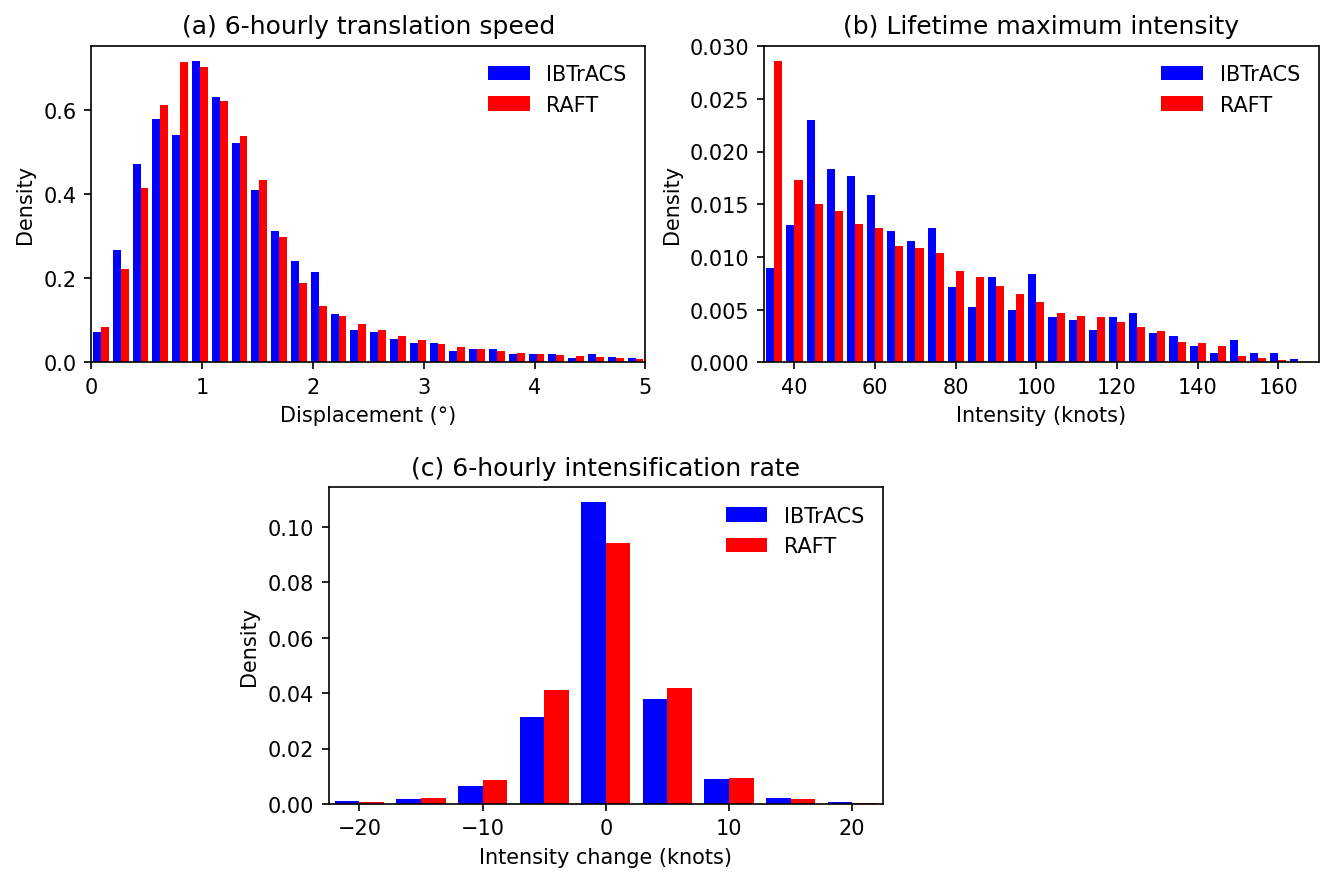

In [65]:
fig = plt.figure(figsize=(11*0.8,8*0.8),dpi=150)

ax = fig.add_axes([0.06,0.54, 0.42,0.33])
bins = np.linspace(0,5,29)
ax.hist([transpd_obs, transpd_syn],bins=bins, density=True, color=['blue', 'red'],label=['IBTrACS', 'RAFT'])
ax.set_xlim([0,5])
ax.set_xlabel('Displacement (\N{DEGREE SIGN})')
ax.set_title('(a) 6-hourly translation speed')
ax.set_ylabel('Density')
ax.legend(frameon=False)

ax = fig.add_axes([0.57,0.54, 0.42,0.33])
temp = vs0_hist_max[1420:]
temp = temp[temp>33] # filter out observed tracks that does not reach the synthetic genesis intensity
bins = np.linspace(32.5,172.5,29)
ax.hist([temp, vs0_syn_max],bins=bins, density=True, color=['blue', 'red'],label=['IBTrACS', 'RAFT'])
# sns.kdeplot(temp, color='blue', ax=ax,clip=[33,180])
# sns.kdeplot(vs0_syn_max, color='red', ax=ax,clip=[33,180])
ax.legend(frameon=False)
ax.set_xlim([32.5,170])
ax.set_xlabel('Intensity (knots)')
ax.set_title('(b) Lifetime maximum intensity')
ax.set_ylabel('Density')

ax = fig.add_axes([0.24,0.08, 0.42,0.33])
bins = np.linspace(-22.5,22.5,10)
ax.hist([vs6_ls, vs6_syn_ls],bins=bins, density=True, color=['blue', 'red'],label=['IBTrACS', 'RAFT'])
ax.set_xlim([-22.5,22.5])
ax.set_xlabel('Intensity change (knots)')
ax.set_title('(c) 6-hourly intensification rate')
ax.set_ylabel('Density')
ax.legend(frameon=False)
#plt.tight_layout()
plt.savefig('analysis/figure D transpds and intensity histogram.png', dpi=330)

### Landfall at cities count

In [14]:
city_name_df = pd.read_csv('Dataset_paper_code_and_data/data/city_name.csv')
city_names = city_name_df.name.tolist()[:-1]
city_names[13]

'New York City'

In [21]:
# count TC landfalls at 51 cities

#50 city coordinates to points and then to polygon
coordinates = loadmat('Dataset_paper_code_and_data/data/city_coordinates.mat')
city_lat = coordinates['city_lat'][:-1]
city_lon = coordinates['city_lon'][:-1]

city_point_ls = [Point(xy) for xy in zip(city_lon.reshape(-1,), city_lat.reshape(-1,))]

city_hit_count_obs_new = np.zeros(city_lat.shape)
itrack_ls = []
for icity, city in enumerate(city_point_ls):
    buffer = city.buffer(1)
    
    itrack_ls.append([])
    for i in range(latmc.shape[0]):
        lats = latmc[i,:]
        lons = lonmc[i,:]
        vs = vsmc[i,:]

        lats = lats[vs>34]
        lons = lons[vs>34]
        vs = vs[vs>34]
        
        if len(vs) <2:
            continue
            
        line = LineString([Point(xy) for xy in zip(lons, lats)])   
        
        if line.intersects(buffer):
            city_hit_count_obs_new[icity] += 1
            itrack_ls[icity].append(i)

In [22]:
# TC landfalls intensity at 50 cities

city_hit_vs_obs = np.zeros(city_lat.shape)
ivs_ls = []
for icity, city in enumerate(city_point_ls):
    buffer = city.buffer(1)
    
    ivs_ls.append([])
    for i in range(latmc.shape[0]):
        for j in range(latmc.shape[1]):
            if np.isnan(vsmc[i,j]) or vsmc[i,j] < 25:
                continue
            if hourmc[i,j] not in list(range(0,24,6)):
                continue
            if ((latmc[i,j]-city_lat[icity])**2 + (lonmc[i,j]-city_lon[icity])**2)**0.5 <=1:
                ivs_ls[icity].append(vsmc[i,j])
                
    city_hit_vs_obs[icity] = np.mean(ivs_ls[icity])
    print(icity, city_hit_vs_obs[icity], end=', ')
    
#city_hit_vs_obs

0 [39.375], 1 [44.47368421], 2 [43.4], 3 [41.84210526], 4 [47.5], 5 [47.5], 6 [48.14285714], 7 [46.57142857], 8 [50.81395349], 9 [46.52173913], 10 [52.39583333], 11 [46.66666667], 12 [49.2], 13 [49.03846154], 14 [46.4], 15 [48.07692308], 16 [45.8], 17 [46.875], 18 [46.4], 19 [47.72727273], 20 [46.875], 21 [46.25], 22 [47.17391304], 23 [39.13043478], 24 [45.24390244], 25 [45.78947368], 26 [54.25531915], 27 [47.25], 28 [49.6124031], 29 [47.84], 30 [47.95454545], 31 [50.76], 32 [50.8], 33 [50.51181102], 34 [58.0075188], 35 [57.32824427], 36 [53.89285714], 37 [55.60606061], 38 [64.2173913], 39 [50.9765625], 40 [52.44094488], 41 [54.80392157], 42 [54.46280992], 43 [51.33802817], 44 [52.33870968], 45 [52.31132075], 46 [59.36619718], 47 [55.15463918], 48 [51.90721649], 49 [54.6350365], 50 [46.], 

In [23]:
for i in range(len(city_names)):
    print(city_names[i], len(itrack_ls[i]), itrack_ls[i])

Bangor 19 [98, 148, 261, 331, 430, 553, 625, 667, 712, 734, 777, 831, 1086, 1177, 1281, 1608, 1784, 1848, 1890]
Machias 28 [148, 396, 430, 485, 532, 551, 553, 560, 572, 718, 734, 750, 831, 845, 951, 966, 1086, 1177, 1209, 1266, 1291, 1405, 1471, 1784, 1848, 1890, 2051, 2133]
Bath 29 [98, 148, 155, 256, 261, 331, 430, 551, 625, 646, 667, 681, 712, 734, 777, 829, 831, 966, 987, 1086, 1279, 1281, 1289, 1290, 1784, 1848, 1890, 2051, 2133]
Portland 30 [98, 148, 155, 256, 261, 331, 389, 551, 625, 646, 667, 681, 712, 734, 777, 829, 831, 966, 987, 1086, 1207, 1279, 1281, 1289, 1290, 1784, 1848, 1890, 2051, 2133]
Gloucester 40 [98, 148, 155, 256, 261, 310, 331, 363, 389, 396, 547, 551, 572, 646, 667, 681, 734, 750, 771, 777, 829, 831, 882, 966, 1086, 1207, 1209, 1266, 1279, 1281, 1289, 1290, 1338, 1784, 1848, 1890, 2028, 2051, 2133, 2275]
Marblehead 42 [13, 98, 148, 155, 256, 261, 310, 331, 363, 389, 396, 547, 551, 646, 667, 681, 734, 750, 771, 777, 829, 831, 882, 966, 981, 987, 1086, 1207, 120

In [52]:
# # calculate synthetic count:
city_hit_count_syn = np.zeros(city_lat.shape)
itrack_syn_ls = []
for icity, city in enumerate(city_point_ls):
    print(icity, city, end=', ')
    itrack_syn_ls.append([])

    buffer = city.buffer(1)
for i in range(lonsyn.shape[0]):
    lats = latsyn[i,:]
    lons = lonsyn[i,:]
    vs = vmaxsyn[i,:,]

    lats = lats[vs>34]
    lons = lons[vs>34]
    vs = vs[vs>34]

    if vs.shape[0]<2:
        continue

    line = LineString([Point(xy) for xy in zip(lons, lats)]) 
    
    for icity, city in enumerate(city_point_ls):
        buffer = city.buffer(1)

        if line.intersects(buffer):
            city_hit_count_syn[icity] += 1
            itrack_syn_ls[icity].append(i)

0 POINT (-68.770278 44.803611), 1 POINT (-67.466667 44.683333), 2 POINT (-69.82250000000001 43.916389), 3 POINT (-70.266667 43.666667), 4 POINT (-70.66249999999999 42.615833), 5 POINT (-70.858333 42.5), 6 POINT (-71.06361099999999 42.358056), 7 POINT (-71.422222 41.823611), 8 POINT (-70.93472199999999 41.636111), 9 POINT (-72.92361099999999 41.31), 10 POINT (-70.09944400000001 41.282778), 11 POINT (-74.172574 40.72422), 12 POINT (-74.071 40.714), 13 POINT (-74.0059 40.7127), 14 POINT (-74.19353 40.666261), 15 POINT (-74.11022800000001 40.662411), 16 POINT (-74.271331 40.52016), 17 POINT (-75.166667 39.95), 18 POINT (-75.105 39.94), 19 POINT (-75.372778 39.847222), 20 POINT (-75.23996 39.839975), 21 POINT (-75.546667 39.745833), 22 POINT (-75.472553 39.568236), 23 POINT (-76.61666700000001 39.283333), 24 POINT (-75.593333 38.365833), 25 POINT (-76.2 36.916667), 26 POINT (-77.912222 34.223333), 27 POINT (-79.933333 32.783333), 28 POINT (-81.11666700000001 32.016667), 29 POINT (-81.491389

In [29]:
# TC landfalls intensity at 50 cities for RAFT TCs

city_hit_vs_syn = np.zeros(city_lat.shape)
ivs_syn_ls = []

for icity, city in enumerate(city_point_ls):
    ivs_syn_ls.append([])

    for i in range(lonsyn.shape[0]):
        lats = latsyn[i,:]
        lons = lonsyn[i,:]
        vs = vmaxsyn[i,:] 
        for j in range(lonsyn.shape[1]):
            if np.isnan(vs[j]) or vs[j] < 25:
                continue

            if ((lats[j]-city_lat[icity])**2 + (lons[j]-city_lon[icity])**2)**0.5 <=1:
                ivs_syn_ls[icity].append(vs[j])
                
    city_hit_vs_syn[icity] = np.mean(ivs_syn_ls[icity])
    print(icity, city_hit_vs_syn[icity], end=', ') 

0 [34.07004166], 1 [35.66641235], 2 [34.35044861], 3 [34.46849442], 4 [35.89375305], 5 [35.60970688], 6 [35.37730026], 7 [36.12532043], 8 [37.65552521], 9 [35.44857025], 10 [40.48350525], 11 [33.98539352], 12 [34.2264328], 13 [34.16851044], 14 [34.0502243], 15 [34.26429367], 16 [34.53066254], 17 [33.83423996], 18 [33.91567993], 19 [33.87707138], 20 [34.00930405], 21 [33.9706192], 22 [34.167099], 23 [33.3801651], 24 [36.18267441], 25 [36.97818375], 26 [40.00126266], 27 [38.56315613], 28 [37.13709259], 29 [38.11645126], 30 [39.7205925], 31 [40.12105179], 32 [40.14225006], 33 [40.22220993], 34 [44.34583664], 35 [44.09173203], 36 [43.49988556], 37 [43.32524872], 38 [44.33130646], 39 [42.12794113], 40 [43.23809433], 41 [40.07135391], 42 [39.95117188], 43 [38.8473053], 44 [40.48233795], 45 [42.57717133], 46 [47.73284531], 47 [40.61459732], 48 [36.79045105], 49 [38.22156143], 50 [35.2931633], 

In [30]:
city_hit_vs99_syn = np.zeros(city_lat.shape)

for icity, city in enumerate(city_point_ls):
                
    city_hit_vs99_syn[icity] = np.percentile(ivs_syn_ls[icity],99)
    print(icity, city_hit_vs99_syn[icity], end=', ') 
    
city_hit_vs99_obs = np.zeros(city_lat.shape)

for icity, city in enumerate(city_point_ls):
                
    city_hit_vs99_obs[icity] = np.percentile(ivs_ls[icity],99)
    print(icity, city_hit_vs99_obs[icity], end=', ') 

0 [57.02126366], 1 [62.97036766], 2 [60.70178101], 3 [62.34929951], 4 [66.75493279], 5 [66.30634834], 6 [62.73892303], 7 [65.87125183], 8 [76.87241104], 9 [68.80484528], 10 [82.0056134], 11 [63.381334], 12 [63.22890488], 13 [63.10550987], 14 [63.22164635], 15 [63.64551678], 16 [63.98823669], 17 [59.59909073], 18 [59.5289183], 19 [59.54735229], 20 [60.91033173], 21 [58.58897427], 22 [58.25585598], 23 [59.27287304], 24 [73.35636673], 25 [76.52825241], 26 [86.72433777], 27 [77.44350632], 28 [73.15718903], 29 [77.70554352], 30 [85.8896666], 31 [89.84253998], 32 [89.88213158], 33 [90.26925278], 34 [105.69308296], 35 [104.99396362], 36 [103.29458939], 37 [103.24538284], 38 [100.76000534], 39 [92.32081123], 40 [94.24971123], 41 [78.93526154], 42 [79.68548721], 43 [79.49553223], 44 [86.75611984], 45 [93.75856171], 46 [107.10785843], 47 [89.68845009], 48 [75.52664436], 49 [85.18199074], 50 [66.99895851], 0 [76.25], 1 [90.5], 2 [75.2], 3 [60.], 4 [80.], 5 [80.], 6 [80.], 7 [83.3], 8 [95.], 9 [72

In [31]:
np.nanmax(vs0_syn_max), np.nanmean(vs0_syn_max), np.nanmedian(vs0_syn_max)

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\numpy\lib\function_base.py:3550: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


(178.39346, 68.635704, 61.990723)

### Landfall city hit count

In [55]:
icity_ls = [13, 25,26,30, 37, 45, 50]
for icity in icity_ls:
    print(city_names[icity])

New York City
Norfolk
Wilmington
Jacksonville
Miami
New Orleans
Houston


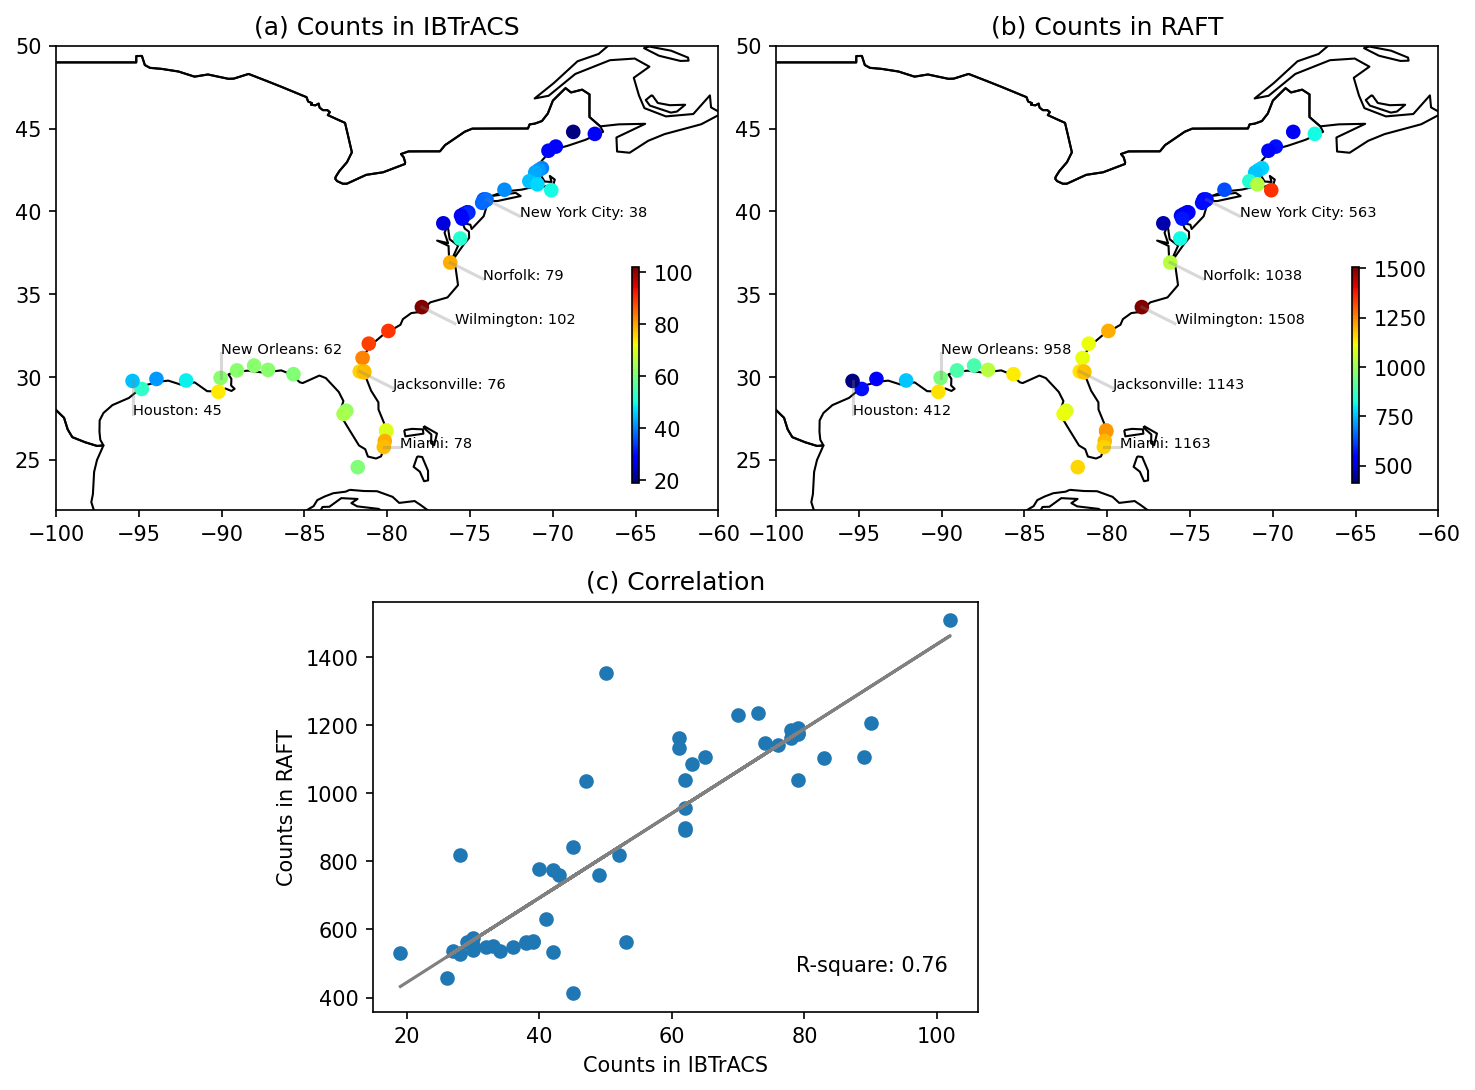

In [53]:
fig = plt.figure(figsize=(12*0.8,9*0.8),dpi=150)

ax = fig.add_axes([0.02,0.5, 0.46,0.48])
ax.set_title('(a) Counts in IBTrACS')
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
ax.set_xlim(-100, -60)
ax.set_ylim(22, 50)
for icity in icity_ls:
    if city_lat[icity]>27 and city_lat[icity]<32 and city_lon[icity]<-87:
        x_setback, y_setback = 0, 1.5
        if city_lon[icity]<-93:
            x_setback, y_setback = 0, -2
    elif city_lat[icity]<27:
        x_setback, y_setback = 1, 0
    else:
        x_setback, y_setback = 2, -1
    ax.text(city_lon[icity]+x_setback,city_lat[icity]+y_setback,city_names[icity]+': '+str(int(city_hit_count_obs_new[icity][0])),fontsize=7)
    ax.plot([city_lon[icity], city_lon[icity]+x_setback], [city_lat[icity], city_lat[icity]+y_setback], color='grey',alpha=0.3)
mycolor = ax.scatter(city_lon, city_lat, c=city_hit_count_obs_new, cmap='jet')
ax = fig.add_axes([0.42,0.55,0.005,0.2])
mycolorbar = plt.colorbar(mycolor,fraction=0.015,cax=ax)

ax = fig.add_axes([0.52,0.5, 0.46,0.48])
ax.set_title('(b) Counts in RAFT')
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
ax.set_xlim(-100, -60)
ax.set_ylim(22, 50)
for icity in icity_ls:
    if city_lat[icity]>27 and city_lat[icity]<32 and city_lon[icity]<-87:
        x_setback, y_setback = 0, 1.5
        if city_lon[icity]<-93:
            x_setback, y_setback = 0, -2
    elif city_lat[icity]<27:
        x_setback, y_setback = 1, 0
    else:
        x_setback, y_setback = 2, -1
    ax.text(city_lon[icity]+x_setback,city_lat[icity]+y_setback,city_names[icity]+': '+str(int(city_hit_count_syn[icity][0])),fontsize=7)
    ax.plot([city_lon[icity], city_lon[icity]+x_setback], [city_lat[icity], city_lat[icity]+y_setback], color='grey',alpha=0.3)
mycolor = ax.scatter(city_lon, city_lat, c=city_hit_count_syn, cmap='jet')
ax = fig.add_axes([0.92,0.55,0.005,0.2])
mycolorbar = plt.colorbar(mycolor,fraction=0.015,cax=ax)

ax = fig.add_axes([0.24,0.06, 0.42,0.38])
ax.set_xlabel('Counts in IBTrACS')
ax.set_ylabel('Counts in RAFT')
ax.scatter(city_hit_count_obs_new,city_hit_count_syn)
regr = linear_model.LinearRegression()
regr.fit(city_hit_count_obs_new, city_hit_count_syn)
pred = regr.predict(city_hit_count_obs_new)
ax.plot(city_hit_count_obs_new, pred, 'grey')
ax.text(0.7,0.1, 'R-square: '+'{0:.2f}'.format(r2_score(city_hit_count_syn, pred)), transform=ax.transAxes)
ax.set_title('(c) Correlation')

#plt.tight_layout()
plt.savefig('analysis/figure D Landfall count at 50 cities.png', dpi=330)

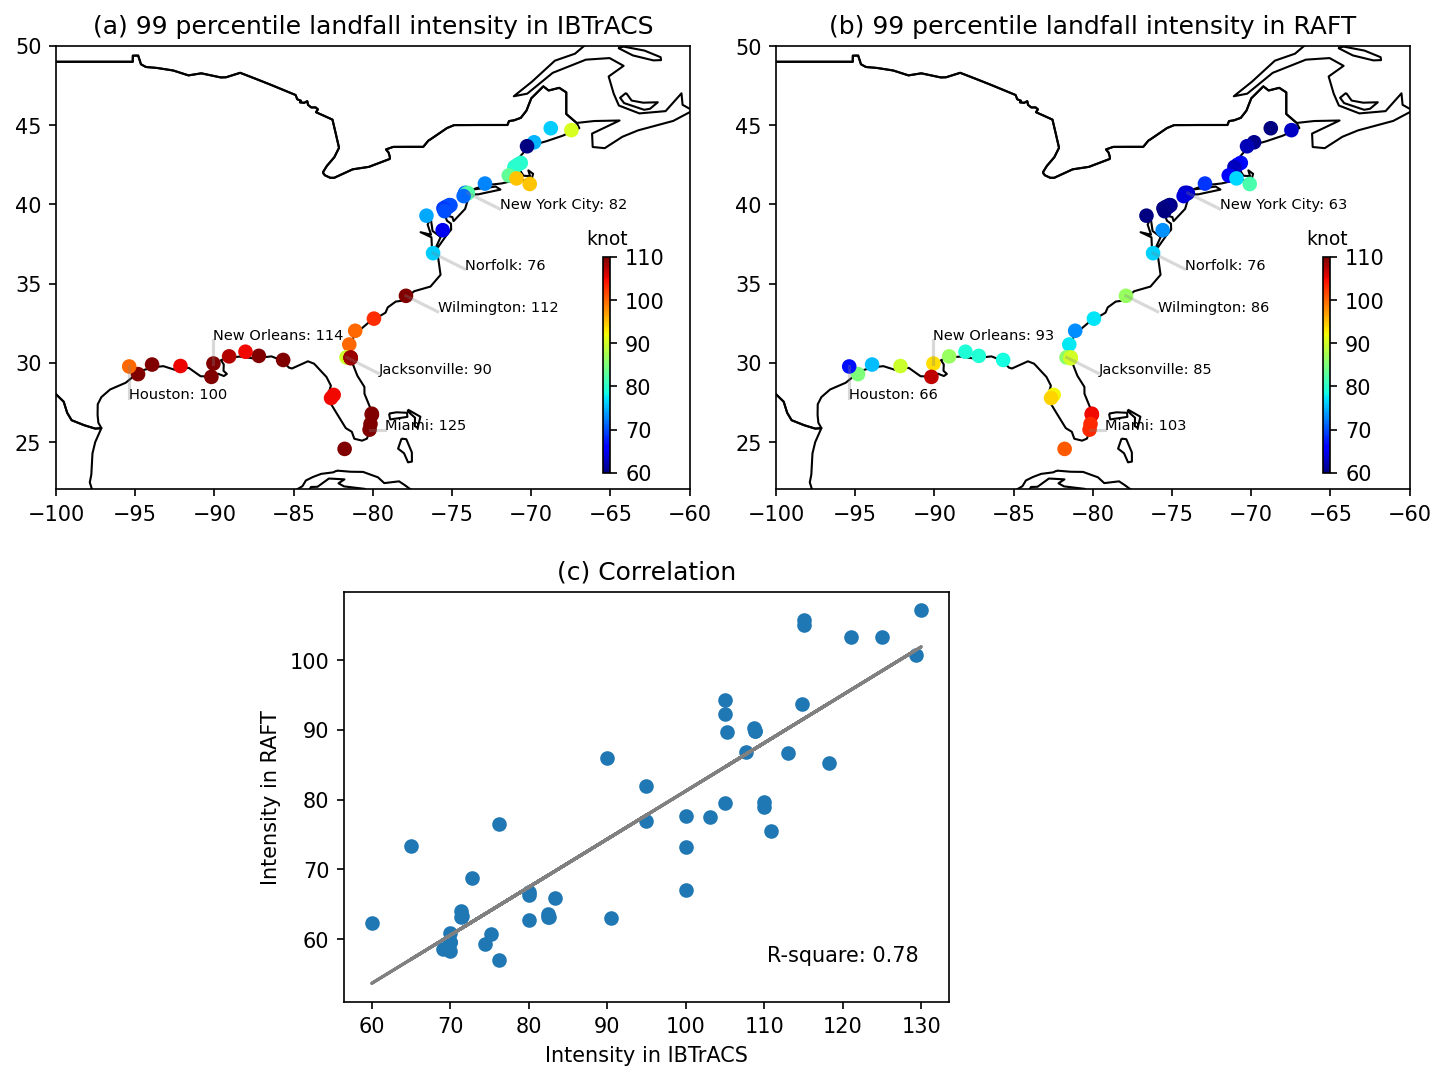

In [34]:
fig = plt.figure(figsize=(12*0.8,9*0.8),dpi=150)

ax = fig.add_axes([0.04,0.5, 0.44,0.48])
ax.set_title('(a) 99 percentile landfall intensity in IBTrACS')
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
ax.set_xlim(-100, -60)
ax.set_ylim(22, 50)
for icity in icity_ls:
    if city_lat[icity]>27 and city_lat[icity]<32 and city_lon[icity]<-87:
        x_setback, y_setback = 0, 1.5
        if city_lon[icity]<-93:
            x_setback, y_setback = 0, -2
    elif city_lat[icity]<27:
        x_setback, y_setback = 1, 0
    else:
        x_setback, y_setback = 2, -1
    ax.text(city_lon[icity]+x_setback,city_lat[icity]+y_setback,city_names[icity]+': '+str(int(city_hit_vs99_obs[icity][0])),fontsize=7)
    ax.plot([city_lon[icity], city_lon[icity]+x_setback], [city_lat[icity], city_lat[icity]+y_setback], color='grey',alpha=0.3)
mycolor = ax.scatter(city_lon, city_lat, c=city_hit_vs99_obs, cmap='jet',vmin=60,vmax=110)
ax = fig.add_axes([0.42,0.55,0.005,0.2])
mycolorbar = plt.colorbar(mycolor,fraction=0.015,cax=ax)
mycolorbar.ax.set_title('knot',fontsize=9)

ax = fig.add_axes([0.54,0.5, 0.44,0.48])
ax.set_title('(b) 99 percentile landfall intensity in RAFT')
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
ax.set_xlim(-100, -60)
ax.set_ylim(22, 50)
for icity in icity_ls:
    if city_lat[icity]>27 and city_lat[icity]<32 and city_lon[icity]<-87:
        x_setback, y_setback = 0, 1.5
        if city_lon[icity]<-93:
            x_setback, y_setback = 0, -2
    elif city_lat[icity]<27:
        x_setback, y_setback = 1, 0
    else:
        x_setback, y_setback = 2, -1
    ax.text(city_lon[icity]+x_setback,city_lat[icity]+y_setback,city_names[icity]+': '+str(int(city_hit_vs99_syn[icity][0])),fontsize=7)
    ax.plot([city_lon[icity], city_lon[icity]+x_setback], [city_lat[icity], city_lat[icity]+y_setback], color='grey',alpha=0.3)
mycolor = ax.scatter(city_lon, city_lat, c=city_hit_vs99_syn, cmap='jet',vmin=60,vmax=110)
ax = fig.add_axes([0.92,0.55,0.005,0.2])
mycolorbar = plt.colorbar(mycolor,fraction=0.015,cax=ax)
mycolorbar.ax.set_title('knot',fontsize=9)


ax = fig.add_axes([0.24,0.06, 0.42,0.38])
ax.set_xlabel('Intensity in IBTrACS')
ax.set_ylabel('Intensity in RAFT')
ax.scatter(city_hit_vs99_obs,city_hit_vs99_syn)
regr = linear_model.LinearRegression()
regr.fit(city_hit_vs99_obs, city_hit_vs99_syn)
pred = regr.predict(city_hit_vs99_obs)
ax.plot(city_hit_vs99_obs, pred, 'grey')
ax.text(0.7,0.1, 'R-square: '+'{0:.2f}'.format(r2_score(city_hit_vs99_syn, pred)), transform=ax.transAxes)
ax.set_title('(c) Correlation')

#plt.tight_layout()
plt.savefig('analysis/figure E Landfall intensity at 50 cities_99percentile.png', dpi=330)

### TC distributions (obs is from 1971)

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


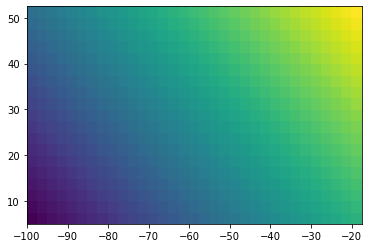

In [35]:
#define the grid: lat 5-55, lon -100, -15
space = 2.5
lat_1d = np.arange(5, 55, space)
lon_1d = np.arange(-100, -15, space)
lon_mesh, lat_mesh = np.meshgrid(lon_1d, lat_1d)
plt.pcolormesh(lon_mesh,lat_mesh, lon_mesh+lat_mesh)

In [36]:
def nine_point_smoother(data):
    # http://www.people.vcu.edu/~mhcrosthwait/clrs322/2DFilteringconcepts.htm
    # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2010GL042487
    result = data.copy()
    m, n = data.shape[0],data.shape[1]
    for i in range(1,m-1):
        for j in range(1,n-1):
            result[i,j] = data[i-1,j-1]*1 + data[i-1,j]*2 + data[i-1,j+1]*1 +\
            data[i,j-1]*2 + data[i,j]*4 + data[i,j+1]*2 +\
            data[i+1,j-1]*1 + data[i+1,j]*2 + data[i+1,j+1]*1
            
            result[i,j] = result[i,j] / 16.0
    return result

In [37]:
# record TCF
def record_TCF(lonmc,latmc, vsmc, obs=False):
    tcf_raw = np.zeros_like(lon_mesh)

    for i in range(latmc.shape[0]):
        for j in range(latmc.shape[1]):
            lat,lon = latmc[i,j], lonmc[i,j]
            if np.isnan(lat):
                break
            if vsmc[i,j] < 25:
                continue
            if obs:
                if hourmc[i,j] not in list(range(0,24,6)):
                    continue
            ilat = int(np.floor((lat - 5) / space))
            ilon = int(np.floor((lon + 100) / space))
            #print(i,j,lat, lon)
            if ilat < 0 or ilat > lon_mesh.shape[0]-1:
                continue
            if ilon < 0 or ilon > lon_mesh.shape[1]-1:
                continue

            tcf_raw[ilat,ilon] += 1

    tcf = nine_point_smoother(tcf_raw)
    #tcf = tcf_raw
    return tcf

In [38]:
# correct lonmc and latmc for TCF purposes
lonmc_tcf = lonmc.copy()
latmc_tcf = latmc.copy()
for i in range(lonmc.shape[0]):
    # if the tracks start with small intensity < 34, fill the lat lon with zero so that they will not enter the tcf count
    if np.where(vsmc[i,:]>=34)[0].shape[0]>0:
        jstart = np.min(np.where(vsmc[i,:]>=34))
    else:
        jstart = lonmc.shape[1]
    lonmc_tcf[i,0:jstart] = 0
    latmc_tcf[i,0:jstart] = 0
    # after the intensity fall below 25 after peak, terminate tracks by changing the lat lon to zero
    for j in range(jstart, lonmc.shape[1]):
        if vsmc[i,j] < 25:
            lonmc_tcf[i,j] = 0
            latmc_tcf[i,j] = 0

In [39]:
#tcf_obs = record_TCF(lonmc_tcf[:,:],latmc_tcf[:,:]) # 1970 [-781:,:]
tcf_obs = record_TCF(lonmc_tcf[1420:,:],latmc_tcf[1420:,:], vsmc[1420:,:], obs=True)
tcf_syn = record_TCF(lonsyn, latsyn, vmaxsyn)

In [40]:
tcf_syn = tcf_syn/lonsyn.shape[0]*num_annual_tc
tcf_obs = tcf_obs/lonmc_tcf[1420:,:].shape[0]*num_annual_tc

In [41]:
## TCF MAE, RMSE
np.nanmean(np.abs(tcf_syn - tcf_obs)), np.sqrt(np.mean(np.square(tcf_syn - tcf_obs)))

(0.2561263407662177, 0.3657935663336153)

In [42]:
tcf_syn[tcf_syn==0] = np.nan
tcf_obs[tcf_obs==0] = np.nan

23720,35343,6637,30280,44566,31019,18898,33867,14696,44295,33201,43595,35541,5167,11071,32031,6548,41084,20084,46182,21418,29547,47463,8170,15905,20026,21372,16639,42309,25902,40390,27859,16415,43458,36432,19694,12420,19775,30257,14119,30719,39560,29106,45562,30441,12680,27383,26001,33686,31226,10101,36425,26297,22377,33134,5884,18878,35923,96,38443,45856,22002,23432,22092,42750,7306,43816,30754,38204,34441,23286,14309,29510,14790,24595,11320,3538,40321,37188,22184,10321,42045,21958,48121,15485,485,16993,24466,5594,2903,26923,47924,1765,45002,26842,15843,23515,7904,37392,16183,47765,40413,48848,21830,41674,22437,11323,47889,39567,41421,15386,14119,3903,10991,29844,23539,6833,43876,47866,43547,18856,33210,4700,11044,48191,7243,14958,4658,17609,48561,14073,44239,34011,41184,46567,49201,16680,47468,24507,47945,2539,24142,2526,23150,25183,38293,25515,40506,35562,10161,26835,20989,47452,49249,7176,22123,44118,4184,5771,6913,25515,12091,3135,19591,17769,23900,7375,11921,40249,11554,7120,1668

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:64: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


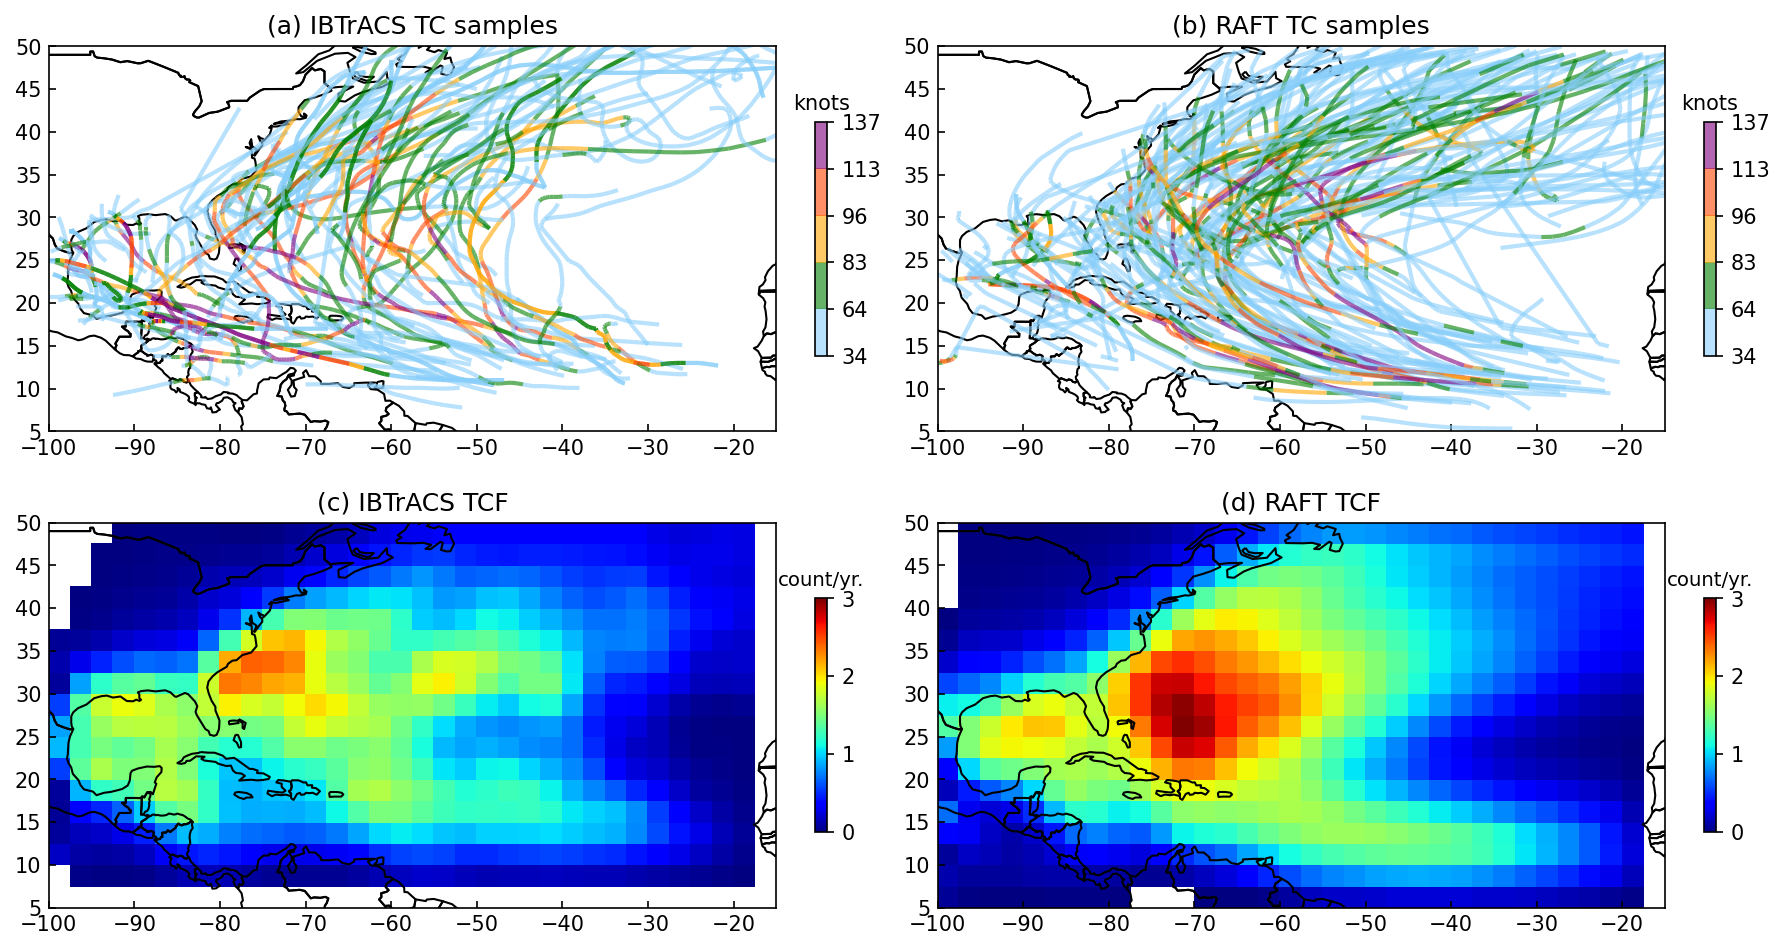

In [43]:
random_seed = 2
cmp = ListedColormap(['lightskyblue','green','orange','orangered','purple'])
norm = BoundaryNorm([34,64,83,96,113,137], cmp.N)

fig,axes = plt.subplots(2,2,dpi=150,figsize=(12,6.5))

ax = axes[0,0]
np.random.seed(random_seed)
for i in np.random.randint(low=1420,high=vsmc.shape[0],size=200):
    x = lonmc[i,:]
    y = latmc[i,:]
    vs = vsmc[i,:]
    vs[vs==0] = np.nan
    vs[vs<34] = np.nan
    x = x[~np.isnan(vs)]
    y = y[~np.isnan(vs)]
    vs = vs[~np.isnan(vs)]
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments_i = np.concatenate([points[:-1], points[1:]], axis=1)
    ##  plot by step intensity
    lc = LineCollection(segments_i, cmap=cmp, norm=norm, alpha=0.6)
    lc.set_array(vs)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
clb = plt.colorbar(line, ax=ax,fraction=0.015)
clb.ax.set_title('knots',fontsize=10)
ax.set_title('(a) IBTrACS TC samples')
    
ax = axes[0,1]
np.random.seed(random_seed)
for i in  np.random.randint(low=0,high=lonsyn.shape[0],size=200):
    print(i, end=',')
    x = lonsyn[i,:]
    y = latsyn[i,:]
    vs = vmaxsyn[i,:]
    vs[vs<34] = np.nan
    x = x[~np.isnan(vs)]
    y = y[~np.isnan(vs)]
    vs = vs[~np.isnan(vs)]

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments_i = np.concatenate([points[:-1], points[1:]], axis=1)
    
    ##  plot by step intensity
    lc = LineCollection(segments_i, cmap=cmp, norm=norm, alpha=0.6)
    lc.set_array(vs)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
world.plot(ax=ax, facecolor='none',edgecolor='k',linewidth=1)
clb = plt.colorbar(line, ax=ax, fraction=0.015)
clb.ax.set_title('knots',fontsize=10)
ax.set_title('(b) RAFT TC samples')

ax = axes[1,0]
mypcolor = ax.pcolormesh(lon_mesh,lat_mesh, tcf_obs,cmap='jet',vmin=0,vmax=3) #,vmin=-0.05,vmax=0.05
clb = plt.colorbar(mypcolor, fraction=0.015,ax=ax)
clb.ax.set_title('count/yr.',fontsize=9.5)
world.plot(ax=ax,edgecolor='k',linewidth=1,facecolor='none')
ax.set_title('(c) IBTrACS TCF')  #1971-2021

ax = axes[1,1]
mypcolor = ax.pcolormesh(lon_mesh,lat_mesh, tcf_syn,cmap='jet',vmin=0,vmax=3) #,vmin=-0.05,vmax=0.05, cmap='Reds'
clb = plt.colorbar(mypcolor, fraction=0.015,ax=ax) #shrink=0.6,
clb.ax.set_title('count/yr.',fontsize=9.5)
world.plot(ax=ax,edgecolor='k',linewidth=1,facecolor='none')
ax.set_title('(d) RAFT TCF')

for ax in axes.flatten():
    ax.set_xlim(-100,-15)
    ax.set_ylim(5,50)
    ax.tick_params(axis='both',direction='in')

plt.tight_layout()
plt.savefig('analysis/TCF and TC samples -200flip.png', dpi=330)

## correlation statistics for TCF

In [44]:
from scipy.stats import pearsonr
temp_a = tcf_syn[(tcf_obs>0)&(tcf_syn>0)]
temp_b = tcf_obs[(tcf_obs>0)&(tcf_syn>0)]
r = pearsonr(temp_a, temp_b)
print('pearson correlation between reanalysis and observation over the NA basin is, with the p-value: ', r)

pearson correlation between reanalysis and observation over the NA basin is, with the p-value:  (0.8900161463037028, 2.190357996896184e-202)


## TC statistics

In [45]:
# get statistics for table:
vs_mean_syn = np.nanmean(vmaxsyn[vmaxsyn>0])
vs_mean_obs = np.nanmean(vsmc[vsmc>0])
vs_mean_syn_std = np.nanstd(vmaxsyn[vmaxsyn>0])
vs_mean_obs_std = np.nanstd(vsmc[vsmc>0])

temp = np.nanmax(vmaxsyn,axis=1)
vs_max_syn = np.nanmean(temp)
vs_max_syn_std = np.nanstd(temp)

temp = np.nanmax(vsmc,axis=1)
vs_max_obs = np.nanmean(temp)
vs_max_obs_std = np.nanstd(temp)

# average pressure
slp_mean_syn = np.nanmean(mslpsyn[vmaxsyn>0])
slp_mean_obs = np.nanmean(slpmc[vsmc>0])
slp_mean_syn_std = np.nanstd(mslpsyn[vmaxsyn>0])
slp_mean_obs_std = np.nanstd(slpmc[vsmc>0])

temp = np.nanmin(mslpsyn,axis=1)
slp_min_syn = np.nanmean(temp)
slp_min_syn_std = np.nanstd(temp)

temp = np.nanmin(slpmc,axis=1)
slp_min_obs = np.nanmean(temp)
slp_min_obs_std = np.nanstd(temp)

#average radius of max wind
rmw_mean_syn = np.nanmean(rmaxsyn[vmaxsyn>0])
rmw_mean_obs = np.nanmean(rmwmc[vsmc>0])
rmw_mean_syn_std = np.nanstd(rmaxsyn[vmaxsyn>0])
rmw_mean_obs_std = np.nanstd(rmwmc[vsmc>0])

df_stat = pd.DataFrame({'index':['Average wind speed along track (knot)',
                                 'Average max wind along track (knot)',
                                 'Average pressure along track (hPa)',
                                 'Average min pressure along track (hPa)',
                                 'Average radius of max wind along track'],
                       'IBTrACS mean':[vs_mean_obs, vs_max_obs, slp_mean_obs, slp_min_obs,rmw_mean_obs],
                       'IBTrACS std':[vs_mean_obs_std, vs_max_obs_std, slp_mean_obs_std, slp_min_obs_std,rmw_mean_obs_std],
                        'RAFT mean':[vs_mean_syn, vs_max_syn, slp_mean_syn, slp_min_syn,rmw_mean_syn],
                       'RAFT std':[vs_mean_syn_std, vs_max_syn_std, slp_mean_syn_std, slp_min_syn_std,rmw_mean_syn_std],
                       '# of std from IBTrACS mean':[(vs_mean_syn-vs_mean_obs)/np.nanstd(vsmc[vsmc>0]), 
                                                     (vs_max_syn-vs_max_obs)/np.nanstd(np.nanmax(vsmc,axis=1)), 
                                                     (slp_mean_syn-slp_mean_obs)/np.nanstd(slpmc[vsmc>0]),
                                                     (slp_min_syn-slp_min_obs)/np.nanstd(np.nanmin(slpmc,axis=1)),
                                                     (rmw_mean_syn-rmw_mean_obs)/np.nanstd(rmwmc[vsmc>0])]})
df_stat = df_stat.set_index('index')
df_stat

C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: All-NaN axis encountered
  import sys
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: All-NaN slice encountered
  # This is added back by InteractiveShellApp.init_path()
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: All-NaN slice encountered
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: All-NaN slice encountered
C:\Users\xuwe421\AppData\Local\Continuum\anaconda3\envs\autokeras\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: All-NaN slice encountered


,IBTrACS mean,IBTrACS std,RAFT mean,RAFT std,# of std from IBTrACS mean
index,,,,,
Average wind speed along track (knot),53.815356,24.427131,46.630856,23.734879,-0.294120
Average max wind along track (knot),68.873397,28.917757,68.646324,29.513052,-0.007852
Average pressure along track (hPa),991.498416,19.073316,996.162903,17.335892,0.244556
Average min pressure along track (hPa),978.905300,24.475607,980.115845,21.581396,0.049459
Average radius of max wind along track,43.970210,30.169240,42.155121,14.416410,-0.060164
